#### JC Penny

 1. **Business understanding** - What business context is the data coming from? What insights would be valuable in that context, and what data would be required for that purporse?

* Define objective or problem definition of the research in respect to company's business and available data
 

In [1]:
##### import libraries for numerical calculations, data and datetime processing
import numpy as np
import pandas as pd
import datetime as dt

# imported for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

#from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import branca.element as be
import branca.colormap as cm

# for processing text data, build model that generates vader score for intensity of customer ratings
import re 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer # vader score processing
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm.notebook import tqdm

# kmeans is used to cross validate vader output and fine tune the vader score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# to build huggy face ai model and make comparison with other librariew
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

2. **Data understanding and preparation** - Explore the data and show you understand its structure and relations, with the aid of appropriate visualisation techniques. Assess the data quality, which insights you would be able to answer from it, and what preparation the data would require. Add new data from another source if required to bring new insights to the data you already have.

In [2]:
#### Load Dataframe
csv_reviews_data = pd.read_csv('data/reviews.csv')
csv_products_data = pd.read_csv('data/products.csv')
csv_user_data = pd.read_csv('data/users.csv')

# The 'lines=True' parameter is used here for json's file to mitigate ValueError: Trailing data
json_reviewers_data = pd.read_json('data/jcpenney_reviewers.json', lines = True)
json_products_data = pd.read_json('data/jcpenney_products.json', lines=True)

In [3]:
# to get the geocordinates of jcpenneys customers
states_lat_long_df = pd.read_csv('data/states_data.csv')
states_lat_long_df.head()

code   latitude   longitude       state
0   AK  63.588753 -154.493062      Alaska
1   AL  32.318231  -86.902298     Alabama
2   AR  35.201050  -91.831833    Arkansas
3   AZ  34.048928 -111.093731     Arizona
4   CA  36.778261 -119.417932  California

##### Exploratory Data Analysis (EDA): 
**(i). reviews.csv and jcpenner_reviewers.json data**

In [4]:
json_reviewers_data.head(3)

Username         DOB          State                            Reviewed
0  bkpn1412  31.07.1983         Oregon  [cea76118f6a9110a893de2b7654319c0]
1  gqjs4414  27.07.1998  Massachusetts  [fa04fe6c0dd5189f54fe600838da43d3]
2  eehe1434  08.08.1950          Idaho                                  []

In [5]:
json_reviewers_data.dtypes

Username    object
DOB         object
State       object
Reviewed    object
dtype: object

In [6]:
json_reviewers_data[json_reviewers_data.astype(str).duplicated()].sum() # returned no duplicated data including the Reviewed column
                                                                    # the type casting method pd.astype(str) is used to fix 'list type unhashable error'
                                                                    # by converting the data passed to pd.duplicated() method to a string type

Username    0
DOB         0
State       0
Reviewed    0
dtype: object

In [7]:
print(f' Returns: {json_reviewers_data['Reviewed'].duplicated().sum()} Numbers of duplicated values in the Reviewed column')

 Returns: 970 Numbers of duplicated values in the Reviewed column


In [8]:
print(f'Data Type of Rows: {type(json_reviewers_data['Reviewed'][2])} \nNumbers of Elements: {len((json_reviewers_data['Reviewed'][2]))}')

Data Type of Rows: <class 'list'> 
Numbers of Elements: 0


**(ii). observation: duplicated rows of empty list**

As revealed by the lines of code above, when the pd.duplicated() method was called on the dataframe, it returned that none of the rows contains duplicated value however when the pd.isna().sum() chained method is called on the 'Reviewed' column as a standalone series from the same dataframe, it returned 970 duplicated rows. A closer investigation using the type() and len() function on targeted row revealed that the column is configured a list data structure and some of them contains zero elements.
The following program will target the rows that has empty lists with a view to extract data including Usernames that corresponds to those rows. The rationale for this is to develop clean data that will be used to filter empty list from the dataframe

In [9]:
# Extract the Username that corresponds to the rows of empty list and present the findings 
# in a tabular form
user_list=[]
reviewed_list=[]
count = 0 # To count the numbers of empty lists in the data and provide a variable for use to double check that the number tallies with the 
          # shape of the data

for user, review in zip(json_reviewers_data['Username'],json_reviewers_data['Reviewed']): # Combine two iterable series(User and Reviewed Column) and
                                                                                          #iterate over each of themusing(user, review) varibles based
                                                                                          # on the order of their respective position
    if len(review)==0:
        count += 1
        user_list.append(user)
        reviewed_list.append(review)

data = {'Username':user_list,'Review':reviewed_list}
empty_list_df = pd.DataFrame(data)
print(f' \nThere are {count} empty list in the Review column which is the same as {empty_list_df.shape[0]} \n')
empty_list_df.head(1)

 
There are 971 empty list in the Review column which is the same as 971 



Username Review
0  eehe1434     []

In [10]:
#an alternative code to check if the head count is the same with the numbers of empty list in the reviewed column is as follows:
count == empty_list_df.shape[0] # The code will return True if the head count and the content of empty list in the table are the same

True

In [11]:
# Extract a dataframe that corresponds to the rows of the empty list with a view to exclude them from the dataset
filter_empty_review_list = json_reviewers_data[json_reviewers_data['Username'].isin(empty_list_df['Username'])]
filter_empty_review_list.head(1)

Username         DOB  State Reviewed
2  eehe1434  08.08.1950  Idaho       []

To exclude them, one method is to delete all 971 rows with empty list using the following line of code:
* json_reviewers_data[~json_reviewers_data.isin(filter_empty_review_list)].dropna(how='all'), 

but the downside is that this dropna(how='all') delete all operation will create the risk loosing important data e.g. Usernames that will be relevant data to our future findings. Therefore the alternative solution is to delete the 'Reviewed' column. This is a more favorable approach because the information contained there is a condensed duplicate of information which are found in the reviews.csv data. By doing this, we can keep the complete Username column and still retain information about Users review. But before deleting the Reviewed column, it is proper to study if it has a relationship with the Username column

**(iii). Username and Reviewed colums**

In [12]:
json_reviewers_data[['Username','Reviewed']].iloc[3,:] # Randomly selected row to show Username and Reviewed column

Username                                             hkxj1334
Reviewed    [f129b1803f447c2b1ce43508fb822810, 3b0c9bc0be6...
Name: 3, dtype: object

In [13]:
json_reviewers_data['Username'][3]

'hkxj1334'

In [14]:
# This contains a list of the unique_id of two items that was reviewed by the Username hkxj1334
json_reviewers_data['Reviewed'][3]

['f129b1803f447c2b1ce43508fb822810', '3b0c9bc0be65a3461893488314236116']

##### (a). assumption: duplicated username in database

Users can review multiple items because for each unique Username, the Reviewed column contains a lists of uniq_id of items that has been reveiwed by the corresponding user. This leads to the assumption that the user name column of the jcpenneys_reviewers.json data may not contain a duplicated value and if it does, it is a red flag. The Reviewed column may contain as many duplicated product unique_ids' which are reviewed by users. The following program investigates this assumption:

In [15]:
# To ascertain that there are duplicated values in the Username column. Returns True if there are duplicated values
json_reviewers_data.shape[0]!=len(json_reviewers_data['Username'].unique())

True

In [16]:
# To extract the duplicated username
json_reviewers_data['Username'][json_reviewers_data['Username'].duplicated(keep=False)]

731     dqft3311
2619    dqft3311
Name: Username, dtype: object

In [17]:
# to extract a dataframe for duplicated username with a view to verify if the information belongs to one user or multiple users
json_reviewers_data[json_reviewers_data['Username']=='dqft3311']

Username         DOB       State                            Reviewed
731   dqft3311  28.07.1995   Tennessee  [5f280fb338485cfc30678998a42f0a55]
2619  dqft3311  03.08.1969  New Mexico  [571b86d307f94e9e8d7919b551c6bb52]

The above table shows that there are two different users with the same user name but different date of birth and from a different geolocation. This may create a weakness that can compromise the integrity of the database with the potential to lead to possible cyber security threats to the organisation. To further investigate this username, we can pass it to the reviews.csv data to see how many entries are made by this duplicated username(s):

In [18]:
print(f' There are {csv_reviews_data[csv_reviews_data['Username']=='dqft3311'].shape[0]} numbers of reviews made by duplicated Username')

 There are 17 numbers of reviews made by duplicated Username


There are 17 reviews with this username and we cannot tell if any of them belongs to the user from New Mexico or Tennessee. As a result, this username will not be suitable for future operations hence will also be excluded from both datasets.

**Data to delete:**
1. The Reviewed column of the jcpenney_reviewers.json data.
   
     <b>Justification to delete:</b>
   * a. It contains 971 rows of empty list
   * b. Deleting the column instead of the rows will preserve the Username column
   * c. The information contained in the Reviewed column is repeated in the reviews.csv in a different format. 

2. Contents of the Username dqft3311

 **Justification to delete:</b>**
 
 The username is duplicated. Deleting it will ensure data integrity, improve performance of the model, enhance storage capacity and help to mitigate threat of cyber security in the database as a whole

**(b) Create final review dataframe for reviews and reviewers**

- reviewers_df
- reviews_df

In [19]:
# Delete username == dqft3311 from jcpenneys_reviewers.json data and save dataframe as reviewers dataframe
reviewers_df = json_reviewers_data.drop(json_reviewers_data[json_reviewers_data['Username'] == 'dqft3311'].index)

# delete Reviewed column from dataframe
reviewers_df.drop(columns=['Reviewed'], inplace=True)

# Delete username == dqft3311 from reviews.csv data and save dataframe as reviews dataframe
reviews_df=csv_reviews_data.drop(csv_reviews_data[csv_reviews_data['Username'] == 'dqft3311'].index)

In [20]:
reviews_df.isna().sum()

Uniq_id     0
Username    0
Score       0
Review      0
dtype: int64

In [21]:
reviews_df.astype(str).duplicated(keep=False).sum()

np.int64(0)

In [22]:
reviews_df['Review'].astype(str).duplicated(keep=False).sum()

np.int64(15527)

In [23]:
reviews_df.shape

(39046, 4)

**(iv). jcpenney_products.json' and products.csv' data**

In [24]:
json_products_data.head(1)

uniq_id           sku  \
0  b6c0b6bea69c722939585baeac73c13d  pp5006380337   

                                    name_title  \
0  Alfred Dunner® Essential Pull On Capri Pant   

                                         description list_price sale_price  \
0  You'll return to our Alfred Dunner pull-on cap...      41.09      24.16   

        category                 category_tree  average_product_rating  \
0  alfred dunner  jcpenney|women|alfred dunner                   2.625   

                                         product_url  \
0  http://www.jcpenney.com/alfred-dunner-essentia...   

                                  product_image_urls          brand  \
0  http://s7d9.scene7.com/is/image/JCPenney/DP122...  Alfred Dunner   

   total_number_reviews                                            Reviews  \
0                     8  [{'User': 'fsdv4141', 'Review': 'You never hav...   

                                         Bought With  
0  [898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567...

In [25]:
json_products_data.columns

Index(['uniq_id', 'sku', 'name_title', 'description', 'list_price',
       'sale_price', 'category', 'category_tree', 'average_product_rating',
       'product_url', 'product_image_urls', 'brand', 'total_number_reviews',
       'Reviews', 'Bought With'],
      dtype='object')

In [26]:
csv_products_data.head(1)

Uniq_id           SKU  \
0  b6c0b6bea69c722939585baeac73c13d  pp5006380337   

                                          Name  \
0  Alfred Dunner® Essential Pull On Capri Pant   

                                         Description  Price  Av_Score  
0  Youll return to our Alfred Dunner pull-on capr...  41.09     2.625

In [27]:
csv_products_data.columns

Index(['Uniq_id', 'SKU', 'Name', 'Description', 'Price', 'Av_Score'], dtype='object')

**(a). uniqu_id and sku column**

In [28]:
# to have an understanding of the 'uniq_id', 'sku' and 'Bought With' columns with a view to ascertain if there is a relationship in the
# the architectural design of the columns for instance if there is an element of information that can be used to identify the sku which the item 
# belongs to. 
json_products_data[['uniq_id','sku','Bought With']].iloc[:1,:] 

uniq_id           sku  \
0  b6c0b6bea69c722939585baeac73c13d  pp5006380337   

                                         Bought With  
0  [898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567...

In [29]:
json_products_data['Bought With'][0]

['898e42fe937a33e8ce5e900ca7a4d924',
 '8c02c262567a2267cd207e35637feb1c',
 'b62dd54545cdc1a05d8aaa2d25aed996',
 '0da4c2dcc8cfa0e71200883b00d22b30',
 '90c46b841e2eeece992c57071387899c']

In [30]:
print(f'Numbers of elements in the first row of "Bought With": {len(json_products_data['Bought With'][0])}')

Numbers of elements in the first row of "Bought With": 5


In [31]:
# To ascertain if the length of data contained in index[0] of 'Bought With' is the same as the length of data in the 'uniq_id' column of the same 
# row with a view to establish if relationship exists in the data content
len(json_products_data['Bought With'][0][0])==len(json_products_data['uniq_id'][0]) 

True

In [32]:
# To further establish relationship by ascetaining the equality in the data types of same columns
type(json_products_data['Bought With'][0][0])==type(json_products_data['uniq_id'][0])

True

In [33]:
json_products_data[['uniq_id','sku','Bought With']].dtypes

uniq_id        object
sku            object
Bought With    object
dtype: object

The uniq_id provides unique identification of primary items purchased or reviewed by users. In addition customers also buy more products alongside their primary purchases and the uniq_ids of this additional purchases are recorded under the 'Bought With' column to tally with the rows where the unique_id of their primary purchases is documented. From this, we can phantom that with this specific dataset,  the uniq_id may not contain duplicated data, and if it does, it provides a clue to a red flag. The following lines of code is used to verify if the uniq_id column contains any duplicated data. In addition, although the data type of sku column is the same as uniq_id, the contents in the rows did not show any architectural similairity where an element of the uniq_id can be used to identify the sku family where it belongs and vice versa. However, similarity is observed between the 'Bought With' and the 'uniq_id' column because the length and the datatype of each row of the uniq_id and is the same as that of each element of the corresponding 'Bought With' column. The implication of this is that the total numbers of characters contained in each row of the 'Bought With' column is equal to the integral numbers of characters (length) in the uniq_id column multiplied by the number of elements contained in the list of the corresponding row. Hence, the smaller the size of the data content of the uniq_id column, the smaller the size of the data content of the 'Bought With' column  

**(b). validity check of uniq_id column**

Now, we also check the validity of each uniq_id and the total size of the uniq_id column. For validity check, we take the length of index[0] of the column (which equals to 32) and use it to compare the length of every other rows in the column. A row with a different size is a red flag and we futher investigate it for missing or compromising data in corresponding columns

In [34]:
# Returns True if there is no duplicate in the uniq_id column
json_products_data.shape[0] == len(json_products_data['uniq_id'].unique()) # if there is a duplicate, the len(json_products_data['uniq_id'].unique()
                                                                           # will be shorter and the program will return false

True

In [35]:
# The program is designed to ascertain if the numbers of characters in each row of the unique_id is the same. 
uniqId_len_list = [] # data structure to hold the numbers of the head count of characters in each of the rows
for i in range(len(json_products_data['uniq_id'])):
    uniqId_len_list.append(len(json_products_data['uniq_id'][i])) # to add the length of each row uniq_id to uniqId_len_list

# The all() function returns True in this case if the size of data in each index of the uniqId_len_list is the same else False
all(index == uniqId_len_list[0] for index in uniqId_len_list)

True

In [36]:
# print(uniqId_len_list)

In [37]:
type(json_products_data['uniq_id'][0]) # to check the type of data in each row of the unique_id

str

In [38]:
print(f' Numbers of characters in each row: {len(json_products_data['uniq_id'][0])}')

 Numbers of characters in each row: 32


In [39]:
print(f' Total numbers of characters in Unique_id Columns: {json_products_data['uniq_id'].shape[0] * len(json_products_data['uniq_id'][0])}')

 Total numbers of characters in Unique_id Columns: 255424


**(c). Findings: the length of the uniq_id json_products_data**

Findings from the precedding programs revealed that each row of the uniq_id contain 32 character string and the number of rows equals to 7982 as a result of which the total numbers of string characters contained equals to twenty five million and five thousand and four hundred and twenty four (255424) characters. The information available suggest that if the number of charcters in each row is reduced by 50%, the organisation can save 50% on storage cost, human readability, speed of processing and mitigate the disadvantage of the multiplier effect when the volume of the data increases.

**(e). sku column** 

The SKU (Stock Keeping Unit) is the family name that contains a group of items identified under the uniq_id. The SKU column may therefore contain duplicated sku names because many standalone items can belong to one family (SKU). As the focus of this study is on individual item, the sku column will be exclusded from the dataset. The following line of codes is used to extract the contents of the columns to be included in final dataframe from this dataset.

**Data to Delete**
* SKU Column
* <b><i>Justification to delete:</i></b>
The column is predicted to contain underlining similar pattern to the uniq_id column as a result of which the final model may suffer from multicolinearity

**(f). Create final dataframe for jcpenneys json product data**
* json_prod_df

In [40]:
json_prod_df = json_products_data[['uniq_id','list_price','sale_price','average_product_rating','total_number_reviews','Reviews', 'Bought With','product_image_urls']]
json_prod_df.head(1)

uniq_id list_price sale_price  \
0  b6c0b6bea69c722939585baeac73c13d      41.09      24.16   

   average_product_rating  total_number_reviews  \
0                   2.625                     8   

                                             Reviews  \
0  [{'User': 'fsdv4141', 'Review': 'You never hav...   

                                         Bought With  \
0  [898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567...   

                                  product_image_urls  
0  http://s7d9.scene7.com/is/image/JCPenney/DP122...

In [41]:
json_prod_df.isna().sum()

uniq_id                   0
list_price                0
sale_price                0
average_product_rating    0
total_number_reviews      0
Reviews                   0
Bought With               0
product_image_urls        0
dtype: int64

In [42]:
json_prod_df.dtypes

uniq_id                    object
list_price                 object
sale_price                 object
average_product_rating    float64
total_number_reviews        int64
Reviews                    object
Bought With                object
product_image_urls         object
dtype: object

In [43]:
json_prod_df.astype(str).duplicated().sum() # to solve non hashable error by converting the columns passed to the duplicated method from a list type to
                                            # a string type

np.int64(0)

In [44]:
json_prod_df.shape

(7982, 8)

In [45]:
json_prod_df['product_image_urls'][0]

'http://s7d9.scene7.com/is/image/JCPenney/DP1228201517142050M.tif?hei=380&amp;wid=380&op_usm=.4,.8,0,0&resmode=sharp2&op_usm=1.5,.8,0,0&resmode=sharp'

In [46]:
json_prod_df[['Reviews','Bought With']]['Reviews'][0][0]

{'User': 'fsdv4141',
 'Review': 'You never have to worry about the fit...Alfred Dunner clothing sizes are true to size and fits perfectly. Great value for the money.',
 'Score': 2}

In [47]:
json_prod_df[['Reviews','Bought With']]['Reviews'].astype(str).duplicated(keep=False).sum()

np.int64(0)

In [48]:
json_prod_df[['Reviews','Bought With']]['Bought With'][0]

['898e42fe937a33e8ce5e900ca7a4d924',
 '8c02c262567a2267cd207e35637feb1c',
 'b62dd54545cdc1a05d8aaa2d25aed996',
 '0da4c2dcc8cfa0e71200883b00d22b30',
 '90c46b841e2eeece992c57071387899c']

In [49]:
json_prod_df[['Reviews','Bought With']]['Bought With'].astype(str).duplicated(keep=False).sum()

np.int64(0)

**(v). products.csv**

In [50]:
json_prod_df.head(1)

uniq_id list_price sale_price  \
0  b6c0b6bea69c722939585baeac73c13d      41.09      24.16   

   average_product_rating  total_number_reviews  \
0                   2.625                     8   

                                             Reviews  \
0  [{'User': 'fsdv4141', 'Review': 'You never hav...   

                                         Bought With  \
0  [898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567...   

                                  product_image_urls  
0  http://s7d9.scene7.com/is/image/JCPenney/DP122...

In [51]:
csv_products_data.head(1)

Uniq_id           SKU  \
0  b6c0b6bea69c722939585baeac73c13d  pp5006380337   

                                          Name  \
0  Alfred Dunner® Essential Pull On Capri Pant   

                                         Description  Price  Av_Score  
0  Youll return to our Alfred Dunner pull-on capr...  41.09     2.625

In [52]:
# To ascertain if the numbers of rows of the two dataframes are equal with a view to prepare them for 
# a join operation. The program will return true if the join operation can be done on the dataframes
json_prod_df.shape[0]==csv_products_data.shape[0]

True

* Presence of null values are brought to the core with the below line of codes. Rationale is to identify columns with null values and apply programatic procedures and appropriate policy to deal with them in a manner that provides maximum benefit to the organization. 

In [53]:
# To identify rows with null values and the total number of null values in each of the column with aview to mitigate inacurate analyses, misleading 
# conclusions and prepare the grounds to make informed decision on the selection of columns that are suitable for model building
csv_products_data.isna().sum()

Uniq_id           0
SKU              67
Name              0
Description     543
Price          2166
Av_Score          0
dtype: int64

In [54]:
# To ascertain that the data type contained in each to column is fit for the respective calculations which is suitable for the model development.
# For instance, an object data type is suitable for string operations while float64 and in data types are suitable for numeric calculations
csv_products_data.dtypes

Uniq_id         object
SKU             object
Name            object
Description     object
Price          float64
Av_Score       float64
dtype: object

In [55]:
#csv_products_data

**(a). columns to exclude and justification for exclusion:**
1. SKU - The SKU is predicted to contains related pattern of datasets with Uniq_id column when both are converted to their numerical equivalent for instance, there is the risk of multicolinearity. 
2. Name - The name represents a unique item just like Unique_id. It also provides the risk of multicolinearity as the data pattern is predicted to be the same as the uniq_id
3. Description - The focus of this project is to process the customer review data. The Description column does not have an immediate relevance to the project objective

**(b). check validity of Uniq_id:</b>**

The following program will ascertain if the length of each row of the Uniq_id is the same because if not the same, it might be a red flag

In [56]:
uniqId_len_list = []
for i in range(len(csv_products_data['Uniq_id'])):
    uniqId_len_list.append(len(csv_products_data['Uniq_id'][i]))

# The all() function returns True in this case if the size of each of the row of Uniq_id isthe same
all(i == uniqId_len_list[0] for i in uniqId_len_list)

True

In [57]:
# Further ascertain if there is a duplicated row under the uniq_id column
# The code will return 0 if there is non
print(f' Numbers of duplicated rows: {csv_products_data['Uniq_id'][csv_products_data['Uniq_id'].duplicated(keep=False)].sum()}')

 Numbers of duplicated rows: 0


In [58]:
print(f'Numbers of null values in Uniq_id of products data: {csv_products_data['Uniq_id'].isna().sum()}')

Numbers of null values in Uniq_id of products data: 0


In [59]:
# To prepare for joining with the json_product_df, the following program will help to ascertain if csv_products_data['Uniq_id'] are the same 
# json_prod_df['uniq_id'].
dummy_list = []
count=0
for i,j in zip(csv_products_data['Uniq_id'], json_prod_df['uniq_id']): 
    # if the rows are not the same, increment count by 1 and add the current value of count to last index of the dummy list
    if i != j:
        count += 1
        dummy_list.append(count)
        
# If the dummy list is empty, then the contents of the two columns are the same        
if len(dummy_list)==0:
    print(f'\nThe Uniq_id in products.csv is the same as Uniq_id in jcpenney_products.json')
else:
    print(f'\nThe Uniq_id in products.csv is not the same as Uniq_id in jcpenney_products.json')
    print(f'\n {dummy_list}')


The Uniq_id in products.csv is the same as Uniq_id in jcpenney_products.json


In [60]:
json_prod_df[['list_price','average_product_rating']].dtypes # ascertain if both datatypes are the same

list_price                 object
average_product_rating    float64
dtype: object

In [61]:
csv_products_data[['Price','Av_Score']].dtypes # to ascertain if both datatypes are the same

Price       float64
Av_Score    float64
dtype: object

In [62]:
# An alternative code for the two line of codes above is to run a direct comparison with a view to return True if both datatypes are the same otherwise 
# False as below. However the above is preferable because you can have a visual appraisal of the difference in the output
print(json_prod_df['list_price'].dtypes == csv_products_data['Price'].dtypes) # datatypes are not the same
print(json_prod_df['average_product_rating'].dtypes == csv_products_data['Av_Score'].dtypes) # same datatypes

False
True


In [63]:
# Retruns True if they contain equal numbers of duplicated data
csv_products_data['Av_Score'].duplicated(keep=False).sum() == json_prod_df['average_product_rating'].duplicated(keep=False).sum()

np.True_

In [64]:
print(f'Numbers of duplicated values in both series: {csv_products_data['Av_Score'].duplicated(keep=False).sum()}')

Numbers of duplicated values in both series: 7946


In [65]:
json_prod_df.shape[0] == csv_products_data.shape[0] # ascertain if series contain same numbers of rows

True

In [66]:
# program to ascertain if the duplicated data are found on the rows with the same index number
index_json_prod_score_duplicated = json_prod_df[json_prod_df['average_product_rating'].duplicated(keep=False)]['average_product_rating'].index

In [67]:
index_csv_prod_score_duplicted = csv_products_data[csv_products_data['Av_Score'].duplicated(keep=False)]['Av_Score'].index

In [68]:
np.unique(index_json_prod_score_duplicated == index_csv_prod_score_duplicted) # returns true if the rows of the duplicated data is the same 

array([ True])

In [69]:
# ascertain if the sum of the values in the columns are the same
round(csv_products_data['Av_Score'].sum(),4) == round(json_prod_df['average_product_rating'].sum(),4) # returns True if the sum are equal

np.True_

**(c). findings:**

Concerning json_prod_df['average_product_rating'] and csv_products_data['Av_Score'], the above investigations reveals the following information:
1. The two columns has the same datatype
2. They have equal numbers of rows
3. Has equal numbers of duplicated datas
4. Same duplicated data are found on the row with the same index number
5. The sum of the values of the column in the same

As a result, the two columns contain the same data although they are extracted from different data files

In [70]:
print(f' Numbers of Null values in Json products dataframe: {json_prod_df['list_price'].isna().sum()}')

 Numbers of Null values in Json products dataframe: 0


In [71]:
print(f' Numbers of Null values in csv products_dataframe: {csv_products_data['Price'].isna().sum()}')

 Numbers of Null values in csv products_dataframe: 2166


In [72]:
print(json_prod_df['list_price'].dtypes == csv_products_data['Price'].dtypes)

False


In [73]:
json_prod_df['list_price'].dtypes

dtype('O')

In [74]:
csv_products_data['Price'].dtypes

dtype('float64')

**(e). observation**

Converting json_prod_df['list price'] to float datatype using json_prod_df['list_price'].astype(float) returns ValueError: could not convert string to float: ''. To investigate this further, we define a function to count the numbers of columns that contains the empty string. Thus, the json file contains empty string while the csv file contains null data. Findings reveal that both columns contain 2166 numbers of unclean data and that the indices of rows of the unclean data are the same for both columns

In [75]:
def count_empty_string(data):
    """
    Function to count numbers of rows that contain empty strings to be used on the list_price column
    """
    count = 0
    for i in data:
        if i == '':
            count += 1
    return count

print(count_empty_string(json_prod_df['list_price']))

2166


In [76]:
# To ascertain if the index number where json_prod_df contains empty data is the same as where csv_products_data contains null data
# Returns True if all of the 2166 rows has matching index numbers
np.unique(json_prod_df[json_prod_df['list_price']=='']['list_price'].index == csv_products_data[csv_products_data['Price'].isna()].index)

array([ True])

**(f). handling null values and empty strings in dataframes**
This section is used to handle the above unclean data.

In [77]:
def handle_unclean(data_1, data_2):
    """The function is designed to fillna and empty strings in two pandas series concurrently using the mean of each series. It first converted the 
    datatypes of the series into an object datatypes and add each numeric row to a corresponding list. The mean of the column is obtained by dividing
    the sum of each list by the length of the corresponding series. The program then sets the new value of the current location where the data is an 
    empty string or a null value with the mean of the corresponding series
    """
    list_data_1 = []
    list_data_2 = []
    if data_1.dtypes != data_1.astype('O'):
        data_1 = data_1.astype(str)
    if data_2.dtypes != data_2.astype('O'):
        data_2 = data_2.astype(str)
    for i,j in zip(data_1,data_2):
        if i.isnumeric():
            list_data_1.append(float(i))
        if j.isnumeric():
            list_data_2.append(float(j))
    for i in range(len(data_1)):
        if (data_1[i]=='') or (data_2[i]==''):
            data_1[i]=str(np.sum(pd.to_numeric(list_data_1, errors='coerce'))/len(data_1))
            data_2[i]=str(np.sum(pd.to_numeric(list_data_2, errors='coerce'))/len(data_2))
        elif(data_1[i]==np.nan) or (data_2[i]==np.nan):
            data_1[i]=str(np.sum(pd.to_numeric(list_data_1, errors='coerce'))/len(data_1))
            data_2[i]=str(np.sum(pd.to_numeric(list_data_2, errors='coerce'))/len(data_2))
    return [data_1, data_2]    
json_prod_df['list_price'],csv_products_data['Price'] = handle_unclean(json_prod_df['list_price'], csv_products_data['Price'])

In [78]:
print(f'Number of Null values in json_prod_df :{json_prod_df['sale_price'].isna().sum()}')

Number of Null values in json_prod_df :0


In [79]:
print(f'Numbers of Null values in csv_products price column: {csv_products_data['Price'].isna().sum()}')

Numbers of Null values in csv_products price column: 0


**(g). create final product dataframe** 

In [80]:
json_prod_df.head(2)

uniq_id list_price sale_price  \
0  b6c0b6bea69c722939585baeac73c13d      41.09      24.16   
1  93e5272c51d8cce02597e3ce67b7ad0a      41.09      24.16   

   average_product_rating  total_number_reviews  \
0                   2.625                     8   
1                   3.000                     8   

                                             Reviews  \
0  [{'User': 'fsdv4141', 'Review': 'You never hav...   
1  [{'User': 'tpcu2211', 'Review': 'You never hav...   

                                         Bought With  \
0  [898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567...   
1  [bc9ab3406dcaa84a123b9da862e6367d, 18eb69e8fc2...   

                                  product_image_urls  
0  http://s7d9.scene7.com/is/image/JCPenney/DP122...  
1  http://s7d9.scene7.com/is/image/JCPenney/DP122...

In [81]:
csv_products_data.head(2)

Uniq_id           SKU  \
0  b6c0b6bea69c722939585baeac73c13d  pp5006380337   
1  93e5272c51d8cce02597e3ce67b7ad0a  pp5006380337   

                                          Name  \
0  Alfred Dunner® Essential Pull On Capri Pant   
1  Alfred Dunner® Essential Pull On Capri Pant   

                                         Description  Price  Av_Score  
0  Youll return to our Alfred Dunner pull-on capr...  41.09     2.625  
1  Youll return to our Alfred Dunner pull-on capr...  41.09     3.000

In [82]:
#json_prod_df.head(2)

In [83]:
products_df = pd.merge(json_prod_df[['uniq_id','Reviews','total_number_reviews','list_price','sale_price']].reset_index(),csv_products_data.drop(columns=['Uniq_id','SKU','Description','Name','Price']).reset_index())
products_df.drop(columns=['index'], inplace=True)

In [84]:
products_df.head(5)

uniq_id  \
0  b6c0b6bea69c722939585baeac73c13d   
1  93e5272c51d8cce02597e3ce67b7ad0a   
2  013e320f2f2ec0cf5b3ff5418d688528   
3  505e6633d81f2cb7400c0cfa0394c427   
4  d969a8542122e1331e304b09f81a83f6   

                                             Reviews  total_number_reviews  \
0  [{'User': 'fsdv4141', 'Review': 'You never hav...                     8   
1  [{'User': 'tpcu2211', 'Review': 'You never hav...                     8   
2  [{'User': 'pcfg3234', 'Review': 'You never hav...                     8   
3  [{'User': 'ngrq4411', 'Review': 'You never hav...                     8   
4  [{'User': 'nbmi2334', 'Review': 'You never hav...                     8   

  list_price sale_price  Av_Score  
0      41.09      24.16     2.625  
1      41.09      24.16     3.000  
2      41.09      24.16     2.625  
3      41.09      24.16     3.500  
4      41.09      24.16     3.125

In [85]:
products_df.dtypes

uniq_id                  object
Reviews                  object
total_number_reviews      int64
list_price               object
sale_price               object
Av_Score                float64
dtype: object

In [86]:
# # ValueError: could not convert string to float: '12.07-60.42' -encountered value error. Used the following code investigate content of column. Uncomment
# the last line of code to see unclean data
list_of_unclean_data = []
for i in products_df['sale_price']:
    if len(i)>5:
        list_of_unclean_data.append(i)
#print(list_of_unclean_data)

In [87]:
#products_df['list_price']=products_df['list_price'].astype(float)
products_df['sale_price']=products_df['sale_price'].str.extract(r'(.{4})', expand=False).astype(float) 
products_df.head()

uniq_id  \
0  b6c0b6bea69c722939585baeac73c13d   
1  93e5272c51d8cce02597e3ce67b7ad0a   
2  013e320f2f2ec0cf5b3ff5418d688528   
3  505e6633d81f2cb7400c0cfa0394c427   
4  d969a8542122e1331e304b09f81a83f6   

                                             Reviews  total_number_reviews  \
0  [{'User': 'fsdv4141', 'Review': 'You never hav...                     8   
1  [{'User': 'tpcu2211', 'Review': 'You never hav...                     8   
2  [{'User': 'pcfg3234', 'Review': 'You never hav...                     8   
3  [{'User': 'ngrq4411', 'Review': 'You never hav...                     8   
4  [{'User': 'nbmi2334', 'Review': 'You never hav...                     8   

  list_price  sale_price  Av_Score  
0      41.09        24.1     2.625  
1      41.09        24.1     3.000  
2      41.09        24.1     2.625  
3      41.09        24.1     3.500  
4      41.09        24.1     3.125

In [88]:
products_df.dtypes

uniq_id                  object
Reviews                  object
total_number_reviews      int64
list_price               object
sale_price              float64
Av_Score                float64
dtype: object

In [89]:
products_df.isna().sum() # to ensure that there are no missing data which can lead to inaccurate analyses, 
                         # biased results and inaccurate results, and the model from running

uniq_id                  0
Reviews                  0
total_number_reviews     0
list_price               0
sale_price              26
Av_Score                 0
dtype: int64

In [90]:
print(f' Numbers of duplicated values: {products_df.astype(str).duplicated(keep=False).sum()}')

 Numbers of duplicated values: 0


In [91]:
# to extract a essential snapshot of the central tendency, dispersion and shape of the final dataframe and thereby understand the basic health, 
# distribution and potential issues that may be associated with the dataframe
products_df.describe()

total_number_reviews   sale_price     Av_Score
count           7982.000000  7956.000000  7982.000000
mean               4.893886    98.719813     2.988683
std                3.314284   337.246047     0.911673
min                1.000000     3.450000     1.000000
25%                2.000000    22.900000     2.500000
50%                4.000000    35.400000     3.000000
75%                8.000000    60.400000     3.500000
max               23.000000  8720.000000     5.000000

In [92]:
products_df.describe(include='object')

uniq_id  \
count                               7982   
unique                              7982   
top     2cc49292b44cc12fe22206440d3e7472   
freq                                   1   

                                                  Reviews list_price  
count                                                7982       7982  
unique                                               7982       1037  
top     [{'User': 'kcqh1322', 'Review': 'This product ...        0.0  
freq                                                    1       2166

In [93]:
products_df[['total_number_reviews','list_price','sale_price','Av_Score']].corr()

total_number_reviews  list_price  sale_price  Av_Score
total_number_reviews              1.000000   -0.013191    0.011189  0.003653
list_price                       -0.013191    1.000000    0.626836  0.003524
sale_price                        0.011189    0.626836    1.000000 -0.001305
Av_Score                          0.003653    0.003524   -0.001305  1.000000

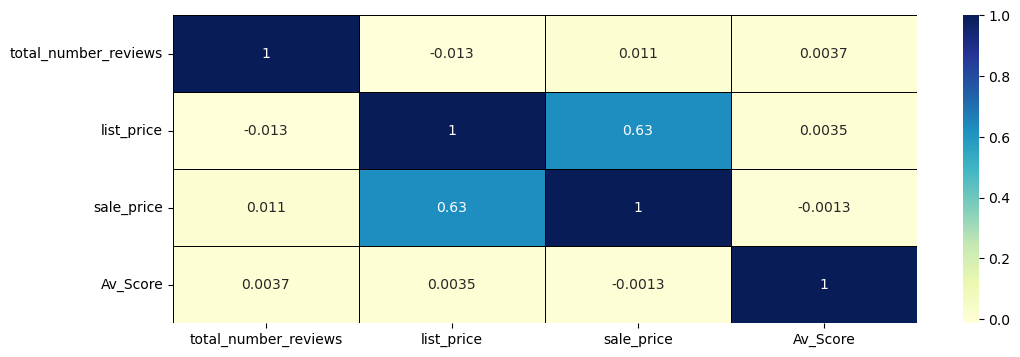

In [94]:
plt.figure(figsize=(12, 4))
sns.heatmap(products_df[['total_number_reviews','list_price','sale_price','Av_Score']].corr(), annot=True, linewidths=.5,cmap="YlGnBu", linecolor='black')
plt.show()

**(vi). Exploration and cleaning: users.csv**

<b>observation:</b>

The user.csv file and the jcpenneys_reviewers.json file has a lot of similarities. The following operation is to asceratin if the degree of similarities with the two data. 

In [95]:
csv_user_data.head(2)

Username         DOB          State
0  bkpn1412  31.07.1983         Oregon
1  gqjs4414  27.07.1998  Massachusetts

In [96]:
reviewers_df.head(2)

Username         DOB          State
0  bkpn1412  31.07.1983         Oregon
1  gqjs4414  27.07.1998  Massachusetts

In [97]:
print(f' Numbers of duplicated Username: {csv_user_data['Username'].duplicated(keep=False).sum()}')

 Numbers of duplicated Username: 2


In [98]:
csv_user_data['Username'][csv_user_data['Username'].duplicated(keep=False)] # The same duplicated user name encountered above in the reviewers data

731     dqft3311
2619    dqft3311
Name: Username, dtype: object

In [99]:
# Similar processing yielding the same result as encountered in the reviewers data
csv_user_data[csv_user_data['Username']=='dqft3311']

Username         DOB       State
731   dqft3311  28.07.1995   Tennessee
2619  dqft3311  03.08.1969  New Mexico

In [100]:
# We drop the repeated username in the user.csv file but this time saved the file in a new dataframe to preserve the original csv_user_data to ensure
# that the change in the content of the file will not affect the output of codes above
csv_df = csv_user_data.drop(csv_user_data[csv_user_data['Username'] == 'dqft3311'].index) 

In [101]:
# This line of code ascertain that reviewers_df is equal to_csv_user_data. The code returns True if they are equal
reviewers_df.equals(csv_df) 

True

Considering that the two datasets are the same, we will now exclude the user.csv data to ensure that duplicated data are not retained in the database.
To conlcude this section, we have carried out exploratory data analysis on the raw datasets and extracted the following dataframes for use in our final models:
1. reviewers_df
2. products_df
3. reviews_df

In [102]:
reviewers_df.head()

Username         DOB          State
0  bkpn1412  31.07.1983         Oregon
1  gqjs4414  27.07.1998  Massachusetts
2  eehe1434  08.08.1950          Idaho
3  hkxj1334  03.08.1969        Florida
4  jjbd1412  26.07.2001        Georgia

In [103]:
products_df.head()

uniq_id  \
0  b6c0b6bea69c722939585baeac73c13d   
1  93e5272c51d8cce02597e3ce67b7ad0a   
2  013e320f2f2ec0cf5b3ff5418d688528   
3  505e6633d81f2cb7400c0cfa0394c427   
4  d969a8542122e1331e304b09f81a83f6   

                                             Reviews  total_number_reviews  \
0  [{'User': 'fsdv4141', 'Review': 'You never hav...                     8   
1  [{'User': 'tpcu2211', 'Review': 'You never hav...                     8   
2  [{'User': 'pcfg3234', 'Review': 'You never hav...                     8   
3  [{'User': 'ngrq4411', 'Review': 'You never hav...                     8   
4  [{'User': 'nbmi2334', 'Review': 'You never hav...                     8   

  list_price  sale_price  Av_Score  
0      41.09        24.1     2.625  
1      41.09        24.1     3.000  
2      41.09        24.1     2.625  
3      41.09        24.1     3.500  
4      41.09        24.1     3.125

In [104]:
#products_df['Reviews'][0]

**(vii). engineering the state feature on the reviews dataframe**

This section creates a state column for the reviews dataframe from the reviewers data frame. The challenge is that both the reviewers dataframe contains 4998 rows while the reviews dataframe contains 39046 rows as a result of which a joint operation will not be possible between them. But using the for loop and the zip() function, we extracted the values, stored it in a list and passed it on to the reviews dataframe as the new state column 

In [105]:
# This is a slow method. The map() function provides a better option and will be used to map latitude and longitudes to the state columns
state_review_list = []
for u in reviews_df['Username']:
    for x,y in zip(reviewers_df['Username'],reviewers_df['State']):
        if u == x:
            state_review_list.append(y)
reviews_df['State']=state_review_list  
reviews_df.isna().sum()

Uniq_id     0
Username    0
Score       0
Review      0
State       0
dtype: int64

In [106]:
reviews_df.shape

(39046, 5)

**(viii). customers birthdays analysis**

This section extract data of customers birthday to help management to farmiliarize with numbers of customers celebrating birthday in a specific month with a view to advance strategic advantages in marketing, operations, and customer relationship management (CRM).

In [107]:
#reviews_df.head(2)

In [108]:
reviewers_df.head(2)

Username         DOB          State
0  bkpn1412  31.07.1983         Oregon
1  gqjs4414  27.07.1998  Massachusetts

In [109]:
print(f'Head count of users birthday: {reviewers_df.shape[0]}')
print(f'Total number of users with share birthday with other users: {reviewers_df['DOB'].astype(str).duplicated(keep=False).sum()}')
print(f'Total number of birthday celebrations in a year: {len(reviewers_df['DOB'].unique())}')

Head count of users birthday: 4998
Total number of users with share birthday with other users: 4998
Total number of birthday celebrations in a year: 52


In [110]:
reviewers_df['DOB'].dtypes #

dtype('O')

In [111]:
# Converts date to date time to enable visualisation of birthday over a period of time.
reviewers_df['DOB'] = pd.to_datetime(reviewers_df['DOB'])
#reviewers_df.head(2)

In [112]:
def extract_date_data(data, d):
    '''
    Program to extract dataframes that corresponds to each birthday and save in list
    data = dataframe
    d = target column e.g date column
    '''
    unique_date_list = []
    unique_date_dict = {}
    count = 0
    for i in data[d].unique():
        unique_date_list.append(data[data[d] == i]) # extract dataframe 
        unique_date_dict[i] = len(unique_date_list[count])
        count += 1
    return[unique_date_list, unique_date_dict]

In [113]:
date_data = extract_date_data(reviewers_df, 'DOB')
date_data[0][0].head()

Username        DOB                 State
0    bkpn1412 1983-07-31                Oregon
7    ibtk1124 1983-07-31           Connecticut
90   msgi1231 1983-07-31             Minnesota
146  fvjg3224 1983-07-31               Vermont
363  wfnl2441 1983-07-31  District of Columbia

In [114]:
date_data[1].values()

dict_values([99, 111, 99, 98, 80, 95, 106, 101, 91, 97, 104, 99, 90, 99, 93, 94, 96, 94, 100, 83, 103, 106, 97, 103, 107, 79, 107, 98, 112, 106, 101, 102, 90, 106, 81, 100, 81, 85, 90, 79, 80, 91, 87, 93, 94, 106, 96, 86, 102, 104, 101, 96])

In [115]:
birthdays_df = pd.DataFrame(date_data[1].values(),date_data[1].keys()).reset_index().rename(columns={'index':'Customers DOB', 0:'Numbers Celebrating'})
birthdays_df.head(1)

Customers DOB  Numbers Celebrating
0    1983-07-31                   99

In [116]:
birthdays_df.dtypes

Customers DOB          datetime64[ns]
Numbers Celebrating             int64
dtype: object

In [117]:
#fig.update_traces(textfont_color='red') # Can also use '#FF0000'

In [118]:
fig= px.scatter(birthdays_df, x='Customers DOB', y='Numbers Celebrating', color='Numbers Celebrating', 
                size='Numbers Celebrating',text='Numbers Celebrating', title='Customers Birthday Over the years',color_continuous_scale=px.colors.sequential.Viridis)
fig.update_traces(textfont_color='#FFF') # Can also use '#FF0000'
fig.update_layout(
    width=1100, # Set chart width in pixels
    height=400  # Set chart height in pixels
)
fig.show()

An alternative visualization for the above plot is the use of bar charts, instead of scatter bubbles however, considering that there are 52 numbers of birthday, this will produce a cluster of 52 columns which will look messy and be unable to convery the necessary information. The above visualisation reveals that the maximum numbers of birthday celebrated was in August 1953 when 112 birthdays was celebrated. While the mostrecent maximum was in July 1998 when 111 numbers of people celebrated. This is a pointer to the fact that the organisation has not increased its customer base since 1950 because the more customers in the database, the more birthdays to celebrate.

**(ix). analysis of frequency of scores** 

In [119]:
def score_count(data_list):
    '''fucntion to count the frequency of each score in the database and convert output to pandas dataframe. 
    The dataframe is used to present a visualization of the frequency of the headcount of the scores
    '''
    count_dict = {}
    for s in data_list:
        if s in count_dict:
            count_dict[s] += 1
        else:
            count_dict[s] = 1
    return pd.DataFrame(count_dict, index=[0]).T.reset_index()
score_counts_df = score_count(list(reviews_df['Score'])).rename(columns={'index':'Scores',0:'Counts'})
score_counts_df.shape

(6, 2)

In [120]:
score_counts_df

Scores  Counts
0       2    7953
1       1   11684
2       0   11260
3       3    4005
4       4    2243
5       5    1901

In [121]:
score_counts_df.sort_values(by='Scores',ascending=True, inplace=True)
score_counts_df['Scores']=score_counts_df['Scores'].astype(str)
score_counts_df.dtypes

Scores    object
Counts     int64
dtype: object

In [122]:
colors_list = ['#FF0000','#FF8A8A','#FFE6E6','#B8FFB8','#00A300','#004700']
fig = px.bar(score_counts_df, y='Counts', x='Scores', text_auto='.4s',color='Scores',color_discrete_sequence=colors_list,
             title="Head count of each score before analysis shows fewer positive sentiments")
fig.update_layout(
    xaxis_title="Categories of Sentiments",
    yaxis_title="Frequency"
)
fig.show()

In [123]:
colors_list = ['#FF0000','#FF8A8A','#FFE6E6','#B8FFB8','#00A300','#004700']
fig = px.pie(values=score_counts_df['Counts'], names=score_counts_df['Scores'], color_discrete_sequence=colors_list, hole=.3, title='Frequency of Intensity of Sentiments of Raw Data')
fig.update_layout(autosize=False, width=800,height=600)
fig.show()

####  3. **Data modeling (optional)** - Would modeling be required for the insights you have considered? Use appropriate techniques, if so.
**(i). Linear Regression model to show relationship between scores and price**

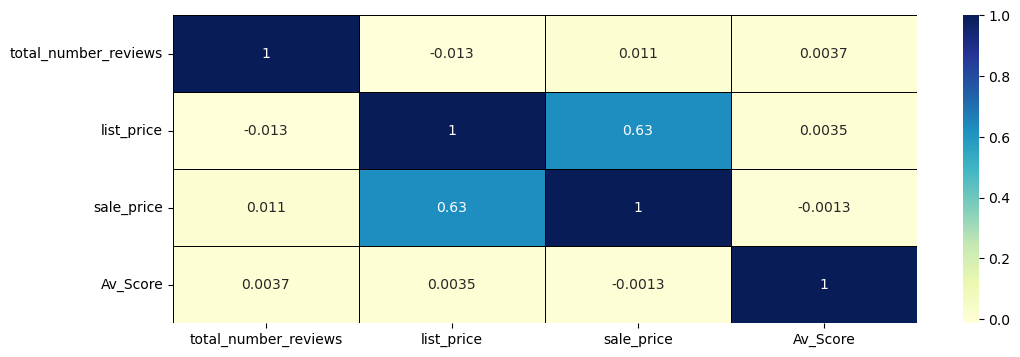

In [124]:
plt.figure(figsize=(12, 4))
sns.heatmap(products_df[['total_number_reviews','list_price','sale_price','Av_Score']].corr(), annot=True, linewidths=.5,cmap="YlGnBu", linecolor='black')
plt.show()

In [125]:
# sns.pairplot(data=products_df[['total_number_reviews','list_price','sale_price','Av_Score']])
# plt.show()

From the above programs a linear relationship does not exists between the average customer scores and the list price or the sale price. As a result average score which is the independent variable will not have a predictive power over the sale price of the item. Hence, the linear regression will be a waste of cost and added overhead that will yield no benefit to the organisation. Hence this investigation will not be taken to the next stage. Although the list price shows a reasonable correlation of about 63% to the sales price, this is expected because a high cost item is expected to be listed with at a reasonable high price that commensurate with its expected selling value. Hence, the relationship between the sales price and the list price is expected to be largely based on management decision

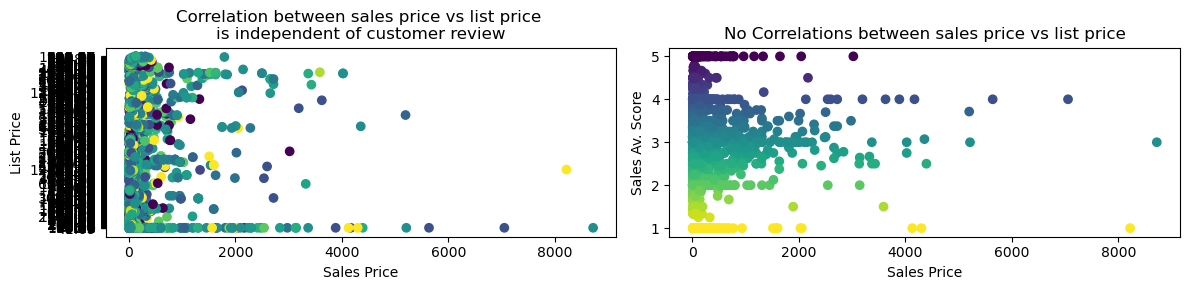

In [126]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 3))
ax1.scatter(products_df['sale_price'], products_df['list_price'], c=products_df['Av_Score'], cmap='viridis_r')
ax1.set_xlabel('Sales Price')
ax1.set_ylabel('List Price')
ax1.set_title('Correlation between sales price vs list price \nis independent of customer review')
ax2.scatter(products_df['sale_price'], products_df['Av_Score'], c=products_df['Av_Score'], cmap='viridis_r')
ax2.set_xlabel('Sales Price')
ax2.set_ylabel('Sales Av. Score')
ax2.set_title('No Correlations between sales price vs list price')
plt.tight_layout()
plt.show()

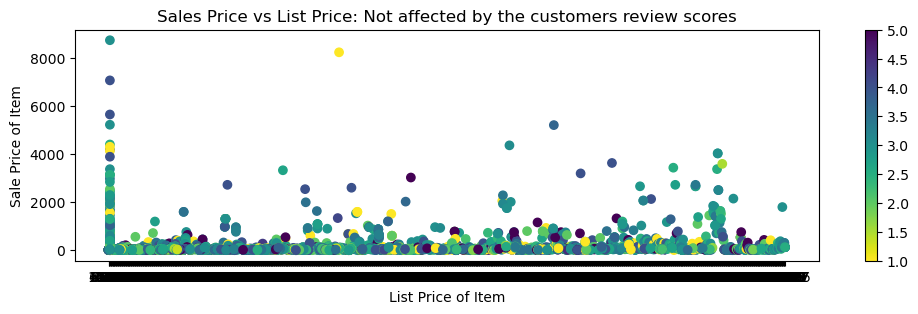

In [127]:
plt.figure(figsize=(12, 3))
plt.scatter(products_df['list_price'],products_df['sale_price'], c=products_df['Av_Score'], cmap='viridis_r')# coloured by customers review score
plt.xlabel('List Price of Item')
plt.ylabel('Sale Price of Item')
plt.colorbar()
plt.title('Sales Price vs List Price: Not affected by the customers review scores')
plt.show()

**(ii). Vader Model**

This section focuses on the Review column. The text data contained in the column are cleaned, chanaged to lower cases, tokenized, lemmatized and vader sentiment analyser model was used to predict the intensity of the customer reviews. The result returned series of values for negative, nuetral, positive and compound scores for each of the customers review. The output of the vader score was compared to the customer scores to ascertain if the scores of the sentiments aligns with the scores provided with the customers. The result indicated that vader model did not fully differentited between the neutral reviews and the positive reviews. In addition, some positive reviews are classified as negative and vice versa.

In [128]:
vader_sent_analyzer = SentimentIntensityAnalyzer() # initialize vader sentiments analyser for use to determine the intensity of the 
                                                   # negativity, neutrality and positivity of customer sentiments on the Review column
vader_sent_analyzer # to ascertain that vader is initialize in the program

In [129]:
porter = PorterStemmer() # To reduces words to their base or root form by removing prefixes and suffixes
lemma = WordNetLemmatizer()

def processing_data(data):
    """
    This function will perform the following functions 1. str.lower() 2. remove all special characters 3. word tokenize, 4. stemmer, 5. lemmatize. It is
    designed to be passed on to the reviews_df['Review'] column
    """
    holding_list = []
    for i in data:
        lower_word_tokenized = str(word_tokenize(i.lower()))
        remove_special_char = re.sub(r'[^\w\s]',"",lower_word_tokenized)
        if not remove_special_char in stopwords.words('english'): # remove stop words
            stem_data = (porter.stem(remove_special_char)) #apply stemer to data
            holding_list.append(lemma.lemmatize(stem_data)) # append lematizer to holding list
    return holding_list

In [130]:
# Use the processing_data() function above to clean the Review column create a new column with it
reviews_df['Cleaned Review'] = processing_data(reviews_df['Review'])
reviews_df['Cleaned Review'].dtypes

dtype('O')

In [131]:
# Vader helper function 
def get_polarity_scores(data, column):
    """
    Function to run sentiment analyzer on all the rows text of the Cleaned Review data and return a pandas dataframe. The output is a dataframe 
    that contains the polority scores of the Cleaned Review column.
    """
    data_structure = []
    for row in data[column]:
        data_structure.append(vader_sent_analyzer.polarity_scores(row)) 
    return pd.DataFrame(data_structure) # to return a new dataframe that contain the polarity scores

In [132]:
# run vader sentiment analyser to generate polarity scores to show the intensity
# of customers sentiments
polarity_scores_df = get_polarity_scores(reviews_df,'Cleaned Review') # to save the output dataframe from the function in a variable
polarity_scores_df.head(2)

neg    neu    pos  compound
0  0.000  0.494  0.506    0.9546
1  0.131  0.264  0.606    0.8408

In [133]:
# Merge polarity_scores_df with reviews_df by creating a dummy index column for use as a common column to both dataframes
score_output_df = pd.merge(polarity_scores_df.reset_index(),reviews_df.reset_index(), on='index')[['Username','State','neg','neu','pos','compound','Score','Cleaned Review']]
score_output_df.head(2)
# an alternative line of code to use to merge the dataframes is pd.concat([reviews_df,polarity_scores_df],axis=1) however this is proned to generating
# Null values in its output thereby may require additional lines of codes which is not desirable

Username           State    neg    neu    pos  compound  Score  \
0  fsdv4141  American Samoa  0.000  0.494  0.506    0.9546      2   
1  krpz1113        Virginia  0.131  0.264  0.606    0.8408      1   

                                      Cleaned Review  
0  you never have to worry about the fit  alfred ...  
1  good quality fabric  perfect fit  washed very ...

In [134]:
score_output_df.shape

(39029, 8)

**(a). analysis of vader scores on the intensity of sentiments - observed inconsistencies in ratings on the Score columns**

The following five lines of code is used to extract customer scores and their reviews for each score. The values of the scores ranges from 0 to 5. It is expected that either 5 or 0 will represent the maximum positive sentiment and vice versa. But after processing the data as shown in the Clean Review column, it is observed that some positive and negative sentiments are classified as 5 and same with the 0 classes. As a result of which the customer scores appear not represent the actual value of the intensity of the customer review sentiments.

In [135]:
print(f' Range of Scores: {score_output_df['Score'].unique()}')

 Range of Scores: [2 1 0 3 4 5]


In [136]:
#score_output_df[(score_output_df['Score']==5)|(score_output_df['Score']== 0)]

In [137]:
# The below result can be extracted into a single dataframe using: score_output_df[(score_output_df['Score']==5)|(score_output_df['Score']== 0)], however, 
# the output witll contain other columns that are not needed. The following codes is preferred because it targets the index of the rows that contains the
# customer reviews thereby showing only the desired data

print(f'Customer Score: {score_output_df.iloc[10]['Score']}, \nCompound Vader: {score_output_df.iloc[10]['compound']} \nCustomer review: {score_output_df[score_output_df['Score']==0]['Cleaned Review'][10]}') # positive sentiment with a 0 score

Customer Score: 0, 
Compound Vader: 0.9492 
Customer review: i do not normally wear pants or capris that have an elastic waist  but i decided to try these since they were on sale and i loved the color  i was very surprised at how comfortable they are and wear really well even wearing all day  i will buy this style again 


In [138]:
# Negative sentiment with 0 customer score and negative vader score
print(f'Customer Score: {score_output_df.iloc[108]['Score']}, \nCompound Vader: {score_output_df.iloc[108]['compound']} \nCustomer review: {score_output_df[score_output_df['Score']==0]['Cleaned Review'][108]}')

Customer Score: 0, 
Compound Vader: -0.4767 
Customer review: i was disappointed in the quality upon closer inspection at home 


In [139]:
#score_output_df[score_output_df['Score']==0].head(50)#['Cleaned Review']

In [140]:
# Positive sentiment with 0 customer score and positive vader score,
print(f'Customer Score: {score_output_df.iloc[60]['Score']}, \nCompound Vader: {score_output_df.iloc[60]['compound']} \nCustomer review: {score_output_df[score_output_df['Score']==0]['Cleaned Review'][60]}')

Customer Score: 0, 
Compound Vader: 0.8176 
Customer review: comfortable and lightweight material for summer wear  love the button accent 


In [141]:
# Positive sentiment with a 5 customer score and a positive vader score
print(f'Customer Score: {score_output_df.iloc[72]['Score']}, \nCompound Vader: {score_output_df.iloc[72]['compound']} \nCustomer review: {score_output_df[score_output_df['Score']==5]['Cleaned Review'][72]}')

Customer Score: 5, 
Compound Vader: 0.6369 
Customer review: i love alfred dunner pants and capris  these have more room in the hip and thigh area than other brands  i can wear a size 10 instead of a 12 because of this 


Vader score on the intensity of sentiments is classified into a range of positive, negative, neutral and a compound score which is used to aggregate the values and determine the class of the overall scores. The following program extracts and visualize the frequencies of the three vader categories as determined by the compound scores.

In [142]:
pos_count = 0
neg_count = 0
neu_count = 0
categories = ['Positive', 'Negative', 'Neutral']
count = [pos_count,neg_count,neu_count]

for val in score_output_df['compound']:
    if val >= 0.05:
        count[0] += 1
    elif val <= -0.05:
        count[1] += 1
    elif -0.05 < val < 0.05:
         count[2] += 1
        
colors_list = ['#004700','#FF0000','grey']
fig = px.bar(x=categories, y=count, color=categories, color_discrete_sequence=colors_list, text_auto='.4s', 
             title='Frequency of Intensity of Sentiments by Vader Rating')
fig.update_layout(
    xaxis_title="Categories of Sentiments",
    yaxis_title="Frequency"
)
fig.show()

In [143]:
fig = px.pie(values=count, names=categories, color_discrete_sequence=colors_list, hole=.3, title='Frequency of Intensity of Sentiments by Vader Rating')
fig.update_layout(autosize=False, width=800,height=600)
fig.show()

In [144]:
score_output_df.iloc[39028]['Cleaned Review']

'less than 10 days the machine stopped and started  ihad to let the machine cool down to work  i will send this back'

In [145]:
score_output_df.iloc[39028]

Username                                                   qzbt3222
State                                                  Rhode Island
neg                                                             0.0
neu                                                           0.781
pos                                                           0.219
compound                                                     0.9617
Score                                                             0
Cleaned Review    less than 10 days the machine stopped and star...
Name: 39028, dtype: object

**(iii). KMeans k=6**

Although the vader model provided a much more improvement to the classification of customers review scores, it however show some irregularities where negative customer reviews are classified as positive for example item at index 39028 was provided with a negative review and rated as 0 by customer but vader assigned it with a score of 0.9617 which is a positive score. As a result of which the kmeans algorithm is used to attempt to further classify the sentitments as unlabelled data with a view to extract business intelligence from the output.

In [146]:
score_output_df.dtypes

Username           object
State              object
neg               float64
neu               float64
pos               float64
compound          float64
Score               int64
Cleaned Review     object
dtype: object

In [147]:
score_output_df.columns

Index(['Username', 'State', 'neg', 'neu', 'pos', 'compound', 'Score',
       'Cleaned Review'],
      dtype='object')

In [148]:
le = LabelEncoder()
score_output_df['encoded_username']=le.fit_transform(score_output_df['Username'])
score_output_df['encoded_state']=le.fit_transform(score_output_df['State'])
score_output_df['encoded_review']=le.fit_transform(score_output_df['Cleaned Review'])
score_output_df.isna().sum()

Username            0
State               0
neg                 0
neu                 0
pos                 0
compound            0
Score               0
Cleaned Review      0
encoded_username    0
encoded_state       0
encoded_review      0
dtype: int64

In [149]:
data_kmeans_model=score_output_df[['encoded_username','encoded_state','Score','encoded_review','compound']]# 'neg','neu','pos','compound'
data_kmeans_model.dtypes 

encoded_username      int64
encoded_state         int64
Score                 int64
encoded_review        int64
compound            float64
dtype: object

In [150]:
kmeans=KMeans(n_clusters=6, n_init=10, random_state=55) #[n_clusters=6 generates classes of 6 different scores[0,1,2,3,4,5]]
kmeans.fit(data_kmeans_model)
labels=kmeans.predict(data_kmeans_model) # classify data into labels
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [151]:
data_kmeans_model['Model Score'] = labels
data_kmeans_model.head(2)

encoded_username  encoded_state  Score  encoded_review  compound  \
0              1093              2      2           29418    0.9546   
1              2051             52      1            3049    0.8408   

   Model Score  
0            4  
1            3

**(a). analysis of kmeans model**

In [152]:
kmeans_model=pd.merge(score_output_df[['Username', 'State','Cleaned Review']].reset_index(),data_kmeans_model.reset_index())
kmeans_model.head(2)

index  Username           State  \
0      0  fsdv4141  American Samoa   
1      1  krpz1113        Virginia   

                                      Cleaned Review  encoded_username  \
0  you never have to worry about the fit  alfred ...              1093   
1  good quality fabric  perfect fit  washed very ...              2051   

   encoded_state  Score  encoded_review  compound  Model Score  
0              2      2           29418    0.9546            4  
1             52      1            3049    0.8408            3

In [153]:
kmeans_model.iloc[39028]

index                                                           39028
Username                                                     qzbt3222
State                                                    Rhode Island
Cleaned Review      less than 10 days the machine stopped and star...
encoded_username                                                 3236
encoded_state                                                      44
Score                                                               0
encoded_review                                                  15350
compound                                                       0.9617
Model Score                                                         5
Name: 39028, dtype: object

In [154]:
kmeans_model.iloc[39028]['Cleaned Review']

'less than 10 days the machine stopped and started  ihad to let the machine cool down to work  i will send this back'

The Kmeans model has classified the review at the same index (39028) as average considering that the intensity range from 0 t0 5. And this is more representative of the actual customer sentiments.

In [155]:
kmeans_counts = score_count(kmeans_model['Model Score']).rename(columns={'index':'Scores',0:'Counts'}).sort_values(by='Scores')
kmeans_counts['Scores']=kmeans_counts['Scores'].astype(str)
kmeans_counts

Scores  Counts
4      0    6653
2      1    6616
3      2    6542
1      3    6762
0      4    5942
5      5    6514

In [156]:
colors_list = ['#FF0000','#FF8A8A','#FFE6E6','#B8FFB8','#00A300','#004700']
fig = px.bar(kmeans_counts, y='Counts', x='Scores', text_auto='.4s',color='Scores',color_discrete_sequence=colors_list,
             title="Headcount of Continuum Intensity of Customer Sentiments (k=6)")
fig.update_layout(
    xaxis_title="Categories of Sentiments",
    yaxis_title="Frequency"
)
fig.show()

In [157]:
colors_list = ['#FF0000','#FF8A8A','#FFE6E6','#B8FFB8','#004700','#00A300']
fig = px.pie(values=kmeans_counts['Counts'], names=score_counts_df['Scores'], color_discrete_sequence=colors_list, hole=.3, title='Percentage of headcount of intensity of customers sentiments (k=6)')
fig.update_layout(autosize=False, width=800,height=600)
fig.show()

In [158]:
kmeans_model[kmeans_model['Model Score'] == 0] # Neutral?

index  Username          State  \
52        52  vivj4111       Delaware   
59        59  gbir2423          Maine   
63        63  xzjf1423         Alaska   
64        64  yrzj4331   Rhode Island   
68        68  upwm2343     Washington   
...      ...       ...            ...   
38866  38866  avlv4411        Vermont   
38968  38968  zzcc2121  West Virginia   
38969  38969  xnkf3423       Kentucky   
38979  38979  pvez3211        Montana   
38980  38980  hnkj3241       Delaware   

                                          Cleaned Review  encoded_username  \
52     the colors and quality of the fabric were fine...              4101   
59     these capris are very comfortable  with just t...              1168   
63     these capris are so comfortable and fit great ...              4585   
64     these capris are very comfortable  with just t...              4735   
68     these capris are so comfortable and fit great ...              3952   
...                                                  ...               ...   
38866  the quality and workmanship is great and well ...               164   
38968  the vacuum is heavy and cumbersome  the automa...              4982   
38969  the model seems solid so far with ample suctio...              4504   
38979  the vacuum is heavy and cumbersome  the automa...              3017   
38980  the model seems solid so far with ample suctio...              1439   

       encoded_state  Score  encoded_review  compound  Model Score  
52                 8      3           20769   -0.3670            0  
59                21      0           23150    0.9392            0  
63                 1      0           23147    0.9313            0  
64                44      3           23150    0.9392            0  
68                53      3           23147    0.9313            0  
...              ...    ...             ...       ...          ...  
38866             51      0           21834   -0.0644            0  
38968             54      1           22467    0.8771            0  
38969             19      0           21432    0.5719            0  
38979             29      0           22467    0.1027            0  
38980              8      5           21432    0.3612            0  

[6653 rows x 10 columns]

In [159]:
#kmeans_model[kmeans_model['k6_score'] == 0]['Cleaned Review'][48]

In [160]:
#kmeans_model[kmeans_model['Model Score'] == 0]['Cleaned Review'][283]

In [161]:
#kmeans_model[kmeans_model['Model Score'] == 0]['Cleaned Review'][310]

In [162]:
#kmeans_model[kmeans_model['Model Score'] == 0]['Cleaned Review'][135]

In [163]:
#kmeans_model[kmeans_model['Model Score'] == 0]['Cleaned Review'][115]

In [164]:
#kmeans_model[kmeans_model['Model Score'] == 5].tail(50)

In [165]:
#kmeans_model[kmeans_model['Model Score'] == 5]['Cleaned Review'][227] # neutral

In [166]:
#kmeans_model[kmeans_model['Model Score'] == 5]['Cleaned Review'][223] # positive

In [167]:
#kmeans_model[kmeans_model['Model Score'] == 5]['Cleaned Review'][38972]# neutral and positive

In [168]:
#kmeans_model[kmeans_model['Model Score'] == 5]['Cleaned Review'][38967] # neutral

In [169]:
#kmeans_model[kmeans_model['Model Score'] == 5]['Cleaned Review'][38868] # neutral

In [170]:
#kmeans_model[kmeans_model['Model Score'] == 5]['Cleaned Review'][144] # neutral

In [171]:
#kmeans_model[kmeans_model['Model Score'] == 5]['Cleaned Review'][38923]# negative 

**(b). fine tune model**

As seen from the visualization above, at k=6, the kmeans model appears to provide a better classification because the intensity appears to be spread across the classes. However, digging deeper into the contents of the rows as shown above, the model still shows weekneses in the fact that both end of the range of the labels (0 and 5) still generates negative and positve sentiments alike. There is no clear distinction between negative and positive

In [172]:
sk_centroids = kmeans.cluster_centers_

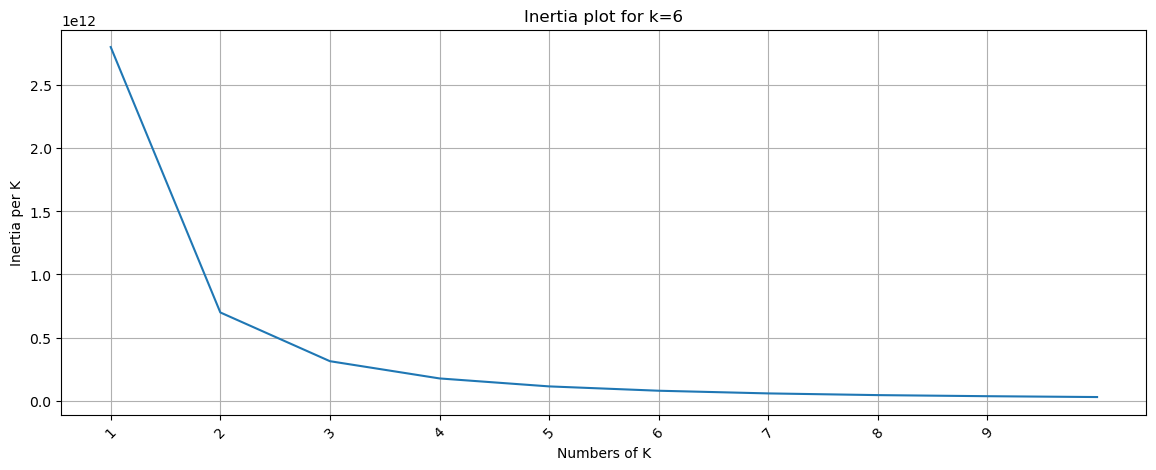

In [173]:
inertia_data = []
for k in np.arange(1,10 + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(kmeans_model[['Score','compound','encoded_review','Model Score']])#'neg','neu','pos',,
    inertia_data.append(kmeans.inertia_)

plt.figure(figsize=(14,5))
plt.plot(np.arange(1,10 + 1), inertia_data)
plt.xticks(np.arange(1,10), rotation=45)
plt.xlabel('Numbers of K')
plt.ylabel('Inertia per K')
plt.grid(True)
plt.title('Inertia plot for k=6')
plt.show()

The inertia above plot reveals that the kmeans algorithm can obtain good result when the value of k ranges between 2 or 3. Kmeans can classify the scores into 0 and 1 where 0 which will represent negative and postive sentiments without any allowance for neutrality. The sharp fall in the plot to elbow = 2 demonstrate that this is the best classification obtainable by kmeans. However, it offers additional classification for neutrality at elbow=3 where the descent of the gradeint is not as decisive. Thus, when the number of classification = 3, negative, neutral, and positive classification can be achieved but there may be chance of possible inconsistency in the classification of the reviews

In [174]:
kmeans_3=KMeans(n_clusters=3, n_init=10, random_state=55) #[n_clusters=6 generates classes of 6 different scores[0,1,2]]
kmeans_3.fit(data_kmeans_model)
labels=kmeans_3.predict(data_kmeans_model) # classify data into labels
np.unique(labels)

array([0, 1, 2], dtype=int32)

In [175]:
kmeans_3

KMeans(n_clusters=3, n_init=10, random_state=55)

In [176]:
data_kmeans_model['k3_score'] = labels
data_kmeans_model.head(3)

encoded_username  encoded_state  Score  encoded_review  compound  \
0              1093              2      2           29418    0.9546   
1              2051             52      1            3049    0.8408   
2              2304             38      2            6606    0.9492   

   Model Score  k3_score  
0            4         1  
1            3         0  
2            1         0

In [177]:
k3_model=pd.merge(score_output_df[['Username','State','Cleaned Review']].reset_index(),data_kmeans_model.drop(columns='Model Score').reset_index()).drop(columns='index')
k3_model.head()

Username                     State  \
0  fsdv4141            American Samoa   
1  krpz1113                  Virginia   
2  mbmg3241  Northern Mariana Islands   
3  zeqg1222               Connecticut   
4  nvfn3212                  Oklahoma   

                                      Cleaned Review  encoded_username  \
0  you never have to worry about the fit  alfred ...              1093   
1  good quality fabric  perfect fit  washed very ...              2051   
2  i do not normally wear pants or capris that ha...              2304   
3  i love these capris  they fit true to size and...              4822   
4  this product is very comfortable and the fabri...              2630   

   encoded_state  Score  encoded_review  compound  k3_score  
0              2      2           29418    0.9546         1  
1             52      1            3049    0.8408         0  
2             38      2            6606    0.9492         0  
3              7      0            9698    0.9292         2  
4             40      3           26428    0.5563         1

In [178]:
#k3_model[k3_model['k3_score']==1].tail(50)

is 1 = positve? Nope!

In [179]:
k3_model[k3_model['k3_score']==1]['Cleaned Review'][39025] # positive

'this is a very good productpicks up everything and the value was very goodi love it '

In [180]:
k3_model[k3_model['k3_score']==1]['Cleaned Review'][0] # positive

'you never have to worry about the fit  alfred dunner clothing sizes are true to size and fits perfectly  great value for the money '

In [181]:
k3_model[k3_model['k3_score']==1]['Cleaned Review'][38883] # neutral

'this is my 4th hoover steam cleaner  my first was way back and had no brushes  my 2nd i still use at our lake home  the 3rd was still working  but was used a lot and we just decided to go for a new one with more features '

In [182]:
k3_model[k3_model['k3_score']==1]['Cleaned Review'][38923]# negative 

'very disappointed '

In [183]:
k3_model[k3_model['k3_score']==1]['Cleaned Review'][38921] # negative

'took the machine to a hoover repair center and i am now without a vacuum for 3 to 4 weeks  gentleman at the repair facility said maybe less time but count on 3 to 4 '

In [184]:
k3_model[k3_model['k3_score']==1]['Cleaned Review'][38940] # negative

'purchased this model via another online retailer because it was a little cheaper  thought hoover would be a quality product however this machine does not equal the quality of a comparable 15 yr old eureka bagged upright  had three weeks before it had to be repaired under warranty at authorized repair shop  no vacuum for 2 weeks  when it was returned for the repair  bearings in beater bar were shot  since being repaired beater bar continues to rotate after being turned off and can not use shut off for beater bar for bare floor use '

In [185]:
k3_model[k3_model['k3_score']==1]['Cleaned Review'][38978] # neutral

'when i unpacked my vaccum i was surprised at how cheaply made the plastic components were  i had difficulty screwing the handle on because the threading was wrong  my first use i was surprised how well it lifted pet hair and cleaned the rug  but theres a weird gap of plastic that i guess is just for decoration on the front where the brush is  that hair and dirt gets caught up in and theres no way to get it out  would recommend to purchase  but definately wouldnt buy this had i had to pay full price '

In [186]:
#k3_model[k3_model['k3_score']==0]

is 0 Neutral?

In [187]:
k3_model[k3_model['k3_score']==0]['Cleaned Review'][1]# positive  

'good quality fabric  perfect fit  washed very well no iron '

In [188]:
k3_model[k3_model['k3_score']==0]['Cleaned Review'][5] # negative

'i did not like the fabric  it is 100  polyester i thought it was differenti bought one at the store apprx two monts ago  and i thought it was just like it'

In [189]:
k3_model[k3_model['k3_score']==0]['Cleaned Review'][39027] # positive

'i found that this vacuum works very well  it really deep cleans like it clams to do             '

In [190]:
k3_model[k3_model['k3_score']==0]['Cleaned Review'][39022] # neutral

'1  the hose is too short  its a stretch to clean in my vehicle or behind furniture  you have a 2 reach  you cant pull it or it will break2  there is a loud hummingwhistling noise that started two weeks after purchase  i checked all the parts  no clogs found  so im not sure what is causing it3  dirt accumulates on the outside of the vacuum  im having to wipe dust off around the entire outside  no different from other vacuums though4  emptying the flipopen dirt cup gets to be a mess  the dirt doesnt just slide out  you have to reach in with your hand and pull out  it empties from the bottom  pic include in this review5  there are several filters which is nice  you can pull out  wash and air dry6  long cord so it reached nearly everywhere without having to constantly unplug and find another outlet7  decent price for the product8  suction is good hopefully it remains that way'

In [191]:
#k3_model[k3_model['k3_score']==2].head(50)

In [192]:
k3_model[k3_model['k3_score']==2]['Cleaned Review'][179]# positive

'love the colors and how it fits  the fabric was better than i thought '

In [193]:
k3_model[k3_model['k3_score']==2]['Cleaned Review'][61] # negative

'i was disappointed in the quality upon closer inspection at home '

In [194]:
k3_model[k3_model['k3_score']==2]['Cleaned Review'][86]# neutral

'it was my mother in laws birthday top this holiday  the detail are always nice on the dunner products and washes very well  the only thing on this one  it seems to be a little smaller than most of the tops i have purchased in the past  do not buy smaller  this top is not fuller as normal  1x was perfect not the xl '

In [195]:
k3_model.columns

Index(['Username', 'State', 'Cleaned Review', 'encoded_username',
       'encoded_state', 'Score', 'encoded_review', 'compound', 'k3_score'],
      dtype='object')

In [196]:
k3_counts = score_count(list(k3_model['k3_score'])).rename(columns={'index':'Scores',0:'Counts'}).sort_values(by='Scores')
k3_counts['Scores']=k3_counts['Scores'].astype(str)
k3_counts

Scores  Counts
1      0   12691
0      1   13384
2      2   12954

In [197]:
colors_list = ['#FF0000','#FFE6E6','#004700']
fig = px.bar(k3_counts, y='Counts', x='Scores', text_auto='.4s',color='Scores',color_discrete_sequence=colors_list,
             title="Headcount of Continuum Intensity of Customer Sentiments (k=3)")
fig.update_layout(
    xaxis_title="Categories of Sentiments",
    yaxis_title="Frequency"
)
fig.show()

In [198]:
colors_list = ['#FF0000','#FFE6E6','#004700']
fig = px.pie(values=k3_counts['Counts'], names=k3_counts['Scores'], color_discrete_sequence=colors_list, hole=.3, title='Percentage of Intensity of headcount of customers sentiments (k=3)')
fig.update_layout(autosize=False, width=800,height=600)
fig.show()

In [199]:
#kmeans_model

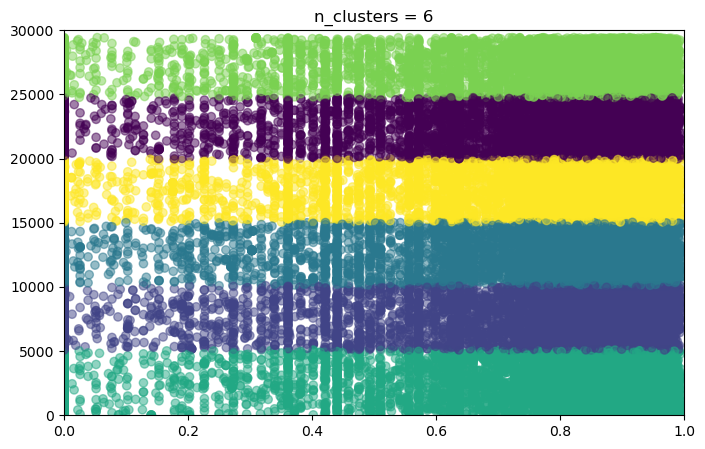

In [200]:
plt.figure(figsize=(8,5))
plt.scatter(kmeans_model['compound'],kmeans_model['encoded_review'],c=kmeans_model['Model Score'],alpha=0.5)
plt.xlim(0,1)
plt.ylim(0,30000)
plt.title('n_clusters = 6')
plt.show()

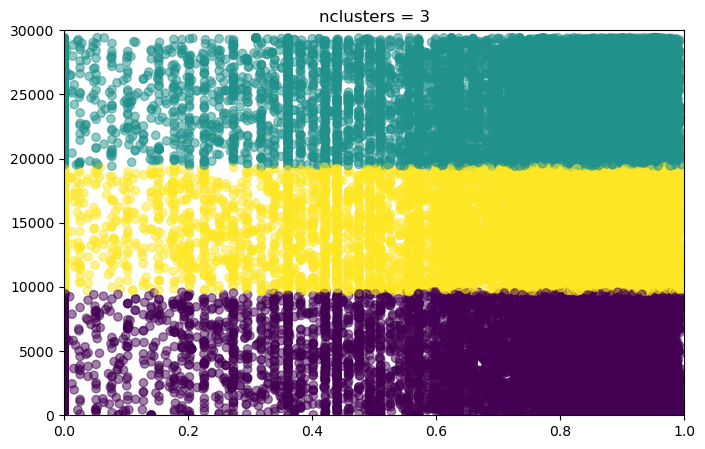

In [201]:
plt.figure(figsize=(8,5))
plt.scatter(k3_model['compound'],k3_model['encoded_review'],c=k3_model['k3_score'],alpha=0.5)
plt.xlim(0,1)
plt.ylim(0,30000)
plt.title('nclusters = 3')
plt.show()

**(c). findings:**

Although kmeans classification did not definitely provide a perfect classification for the text data, howerver it helped to narrow down the margin of error. The output is not convincing hence not suitable for production environment

**(d). hugging face pipeline**

In [202]:
# initialize hugging face classifier
hugging_face_clf = pipeline("sentiment-analysis",device=-1, max_length=512,truncation=True)
hugging_face_clf

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [203]:
# rename 'Model Score' to k6_score to reflect that the score is from kmeans clusters =6
kmeans_model=kmeans_model.rename(columns={'Model Score':'k6_score'})
kmeans_model.head(1)  

index  Username           State  \
0      0  fsdv4141  American Samoa   

                                      Cleaned Review  encoded_username  \
0  you never have to worry about the fit  alfred ...              1093   

   encoded_state  Score  encoded_review  compound  k6_score  
0              2      2           29418    0.9546         4

In [204]:
# run hugging face classifier on the clean data to classify sentiments
# extract 100000 rows of data due to slow cpu processing and build a hugging face model
holding_list = []
for i in range(1000):#10000
    holding_list.append(hugging_face_clf(k3_model['Cleaned Review'][i])[0])
hugging_df = pd.DataFrame(holding_list).rename(columns={'label':'hugging_classification', 'score':'hugging_score'})
hugging_df.head(1)

hugging_classification  hugging_score
0               POSITIVE       0.999861

**(e). analysis of hugging face pipeline classification result**

In [205]:
# Count the numbers of positve and negative classification by hugging face to prepare data to visualize the frequency of each classification
hugging_count_df = pd.DataFrame(hugging_df.hugging_classification.value_counts()).reset_index()
hugging_count_df 

hugging_classification  count
0               POSITIVE    802
1               NEGATIVE    198

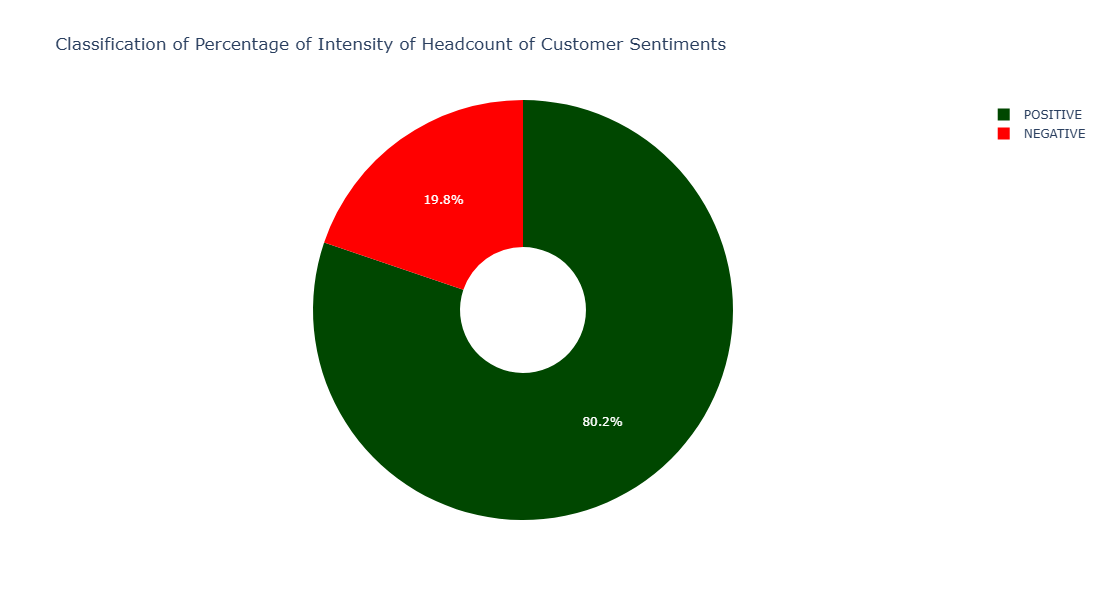

In [206]:
hugging_colors_list = ['#004700','#FF0000']
fig = px.pie(values=hugging_count_df['count'], names=hugging_count_df['hugging_classification'], color_discrete_sequence=hugging_colors_list, hole=.3, title='Classification of Percentage of Intensity of Headcount of Customer Sentiments')
fig.update_layout(autosize=False, width=800,height=600)
fig.show()

In [207]:
hugging_colors_list = ['#004700','#FF0000']
fig = px.bar(hugging_count_df, y='count', x='hugging_classification', text_auto='.4s',color='hugging_classification',color_discrete_sequence=hugging_colors_list,
             title="Hugging Face Classification of Intensity of Headcount of Customer Sentiments")
fig.update_layout(
    xaxis_title="Categories of Sentiments",
    yaxis_title="Frequency"
)
fig.show()

**create data frame for all the results of the classifications - vader,kmeans=6,kmeans=3,hugging face ai**

In [208]:
result_df = pd.concat([hugging_df,k3_model.iloc[0:1000]], axis=1)#10000
result_df.columns

Index(['hugging_classification', 'hugging_score', 'Username', 'State',
       'Cleaned Review', 'encoded_username', 'encoded_state', 'Score',
       'encoded_review', 'compound', 'k3_score'],
      dtype='object')

In [209]:
result_df = result_df[['Username','State','Cleaned Review','hugging_classification','hugging_score','compound','Score', 'k3_score']]
result_df = pd.concat([result_df,kmeans_model['k6_score'][0:1000]], axis=1)#10000
result_df.head(5)

Username                     State  \
0  fsdv4141            American Samoa   
1  krpz1113                  Virginia   
2  mbmg3241  Northern Mariana Islands   
3  zeqg1222               Connecticut   
4  nvfn3212                  Oklahoma   

                                      Cleaned Review hugging_classification  \
0  you never have to worry about the fit  alfred ...               POSITIVE   
1  good quality fabric  perfect fit  washed very ...               POSITIVE   
2  i do not normally wear pants or capris that ha...               POSITIVE   
3  i love these capris  they fit true to size and...               POSITIVE   
4  this product is very comfortable and the fabri...               POSITIVE   

   hugging_score  compound  Score  k3_score  k6_score  
0       0.999861    0.9546      2         1         4  
1       0.994180    0.8408      1         0         3  
2       0.999638    0.9492      2         0         1  
3       0.999589    0.9292      0         2         1  
4       0.999142    0.5563      3         1         4

In [210]:
result_df[result_df['hugging_classification']=='POSITIVE'][:5]

Username                     State  \
0  fsdv4141            American Samoa   
1  krpz1113                  Virginia   
2  mbmg3241  Northern Mariana Islands   
3  zeqg1222               Connecticut   
4  nvfn3212                  Oklahoma   

                                      Cleaned Review hugging_classification  \
0  you never have to worry about the fit  alfred ...               POSITIVE   
1  good quality fabric  perfect fit  washed very ...               POSITIVE   
2  i do not normally wear pants or capris that ha...               POSITIVE   
3  i love these capris  they fit true to size and...               POSITIVE   
4  this product is very comfortable and the fabri...               POSITIVE   

   hugging_score  compound  Score  k3_score  k6_score  
0       0.999861    0.9546      2         1         4  
1       0.994180    0.8408      1         0         3  
2       0.999638    0.9492      2         0         1  
3       0.999589    0.9292      0         2         1  
4       0.999142    0.5563      3         1         4

In [211]:
result_df[result_df['hugging_classification']=='POSITIVE']['Cleaned Review'][999]

'my nephew is adorable in this  it fits well and is very warm '

In [212]:
result_df['hugging_classification'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

In [213]:
result_df[result_df['hugging_classification']=='NEGATIVE'].head(2)

Username     State                                     Cleaned Review  \
48  glvx4212  Oklahoma  i loved the quality and price but it seems alf...   
52  vivj4111  Delaware  the colors and quality of the fabric were fine...   

   hugging_classification  hugging_score  compound  Score  k3_score  k6_score  
48               NEGATIVE       0.998217    0.8793      2         2         2  
52               NEGATIVE       0.986238   -0.3670      3         1         0

In [214]:
#result_df[result_df['hugging_classification']=='NEGATIVE']['Cleaned Review'][998]

In [215]:
result_df[result_df['hugging_classification']=='NEGATIVE']['Cleaned Review'][294]

'it was a very nice suit  but it was falling off my shoulders  way too large in chest and shoulders  i would recommend it if it fit the person '

In [216]:
result_df[result_df['hugging_classification']=='NEGATIVE']['Cleaned Review'][71]

'i was disappointed in the quality upon closer inspection at home '

#### 4. **Evaluation and deployment** - How do the insights you obtained help the company, and how can should they be adopted in their business? If modeling techniques have been adopted, are their use scientifically sound and how should they be mantained?

In [217]:
#!pip install folium

**(a). prepare data to visualize result including handling null values in geographical data**

In [218]:
result_df.columns

Index(['Username', 'State', 'Cleaned Review', 'hugging_classification',
       'hugging_score', 'compound', 'Score', 'k3_score', 'k6_score'],
      dtype='object')

In [219]:
# rename columns to show context
result_df.rename(columns={'Score':'customer_rating','compound':'vader_score'}, inplace=True)

In [220]:
states_lat_long_df.shape[0]

52

In [221]:
len(result_df['State'].unique())

57

In [222]:
# prepare latitude and longitude to add to result data
states_lat_long_df.head(1)

code   latitude   longitude   state
0   AK  63.588753 -154.493062  Alaska

In [223]:
# Map latitude and longitude data to the result_df uisng the map() method
code_lookup = pd.Series(states_lat_long_df['code'].values, index=states_lat_long_df['state']).to_dict()
state_lookup = pd.Series(states_lat_long_df['state'].values, index=states_lat_long_df['state']).to_dict()
latitude_lookup = pd.Series(states_lat_long_df['latitude'].values, index=states_lat_long_df['state']).to_dict()
longitude_lookup = pd.Series(states_lat_long_df['longitude'].values, index=states_lat_long_df['state']).to_dict()

# Apply the values to the result dataframe to create corresponding columns of geographical data for visualization
result_df['code'] = result_df['State'].map(code_lookup)
result_df['latitude'] = result_df['State'].map(latitude_lookup)
result_df['longitude'] = result_df['State'].map(longitude_lookup)

In [224]:
result_df.isna().sum()

Username                   0
State                      0
Cleaned Review             0
hugging_classification     0
hugging_score              0
vader_score                0
customer_rating            0
k3_score                   0
k6_score                   0
code                      97
latitude                  97
longitude                 97
dtype: int64

In [225]:
# List out the states that has not been mapped to latitude and longitude
result_df.loc[result_df.isna().any(axis=1)]['State'].unique()
# an alternative method to achieve the above is shown below by finding the difference in the list of the state columns from both dataframe

array(['American Samoa', 'Northern Mariana Islands',
       'Minor Outlying Islands', 'Guam', 'U.S. Virgin Islands'],
      dtype=object)

In [226]:
# Difference in list
list(set(result_df['State'].unique()) - set(states_lat_long_df['state'].unique()))

['Guam',
 'U.S. Virgin Islands',
 'American Samoa',
 'Northern Mariana Islands',
 'Minor Outlying Islands']

In [227]:
# Source additional latitude and longitude data for the concerned states
lat_long_dict = {'code':['MO','MP','GU','VI','AS'],
                 'state': ['Minor Outlying Islands','Northern Mariana Islands','Guam','U.S. Virgin Islands','American Samoa'],
                 'latitude':[28.2075,15.190000,13.444304,18.036736,-14.275632],
                 'longitude':[-177.35,145.750000,144.793732,-64.801704,-170.702042]  
}
added_lat_long_df=pd.DataFrame(lat_long_dict)
added_lat_long_df

code                     state   latitude   longitude
0   MO    Minor Outlying Islands  28.207500 -177.350000
1   MP  Northern Mariana Islands  15.190000  145.750000
2   GU                      Guam  13.444304  144.793732
3   VI       U.S. Virgin Islands  18.036736  -64.801704
4   AS            American Samoa -14.275632 -170.702042

In [228]:
# add to the new data to the dataframe of latitude and longitude data
latitude_longitude_data = pd.concat([added_lat_long_df,states_lat_long_df],axis=0, ignore_index=True)
latitude_longitude_data.isna().sum()

code         0
state        0
latitude     0
longitude    0
dtype: int64

In [229]:
latitude_longitude_data.head(1)

code                   state  latitude  longitude
0   MO  Minor Outlying Islands   28.2075    -177.35

In [230]:
# Map the new data to the result_df uisng the map() method
code_lookup = pd.Series(latitude_longitude_data['code'].values, index=latitude_longitude_data['state']).to_dict()
state_lookup = pd.Series(latitude_longitude_data['state'].values, index=latitude_longitude_data['state']).to_dict()
latitude_lookup = pd.Series(latitude_longitude_data['latitude'].values, index=latitude_longitude_data['state']).to_dict()
longitude_lookup = pd.Series(latitude_longitude_data['longitude'].values, index=latitude_longitude_data['state']).to_dict()

# Apply the values to the result dataframe to create corresponding columns of geographical data for visualization
result_df['code'] = result_df['State'].map(code_lookup)
result_df['latitude'] = result_df['State'].map(latitude_lookup)
result_df['longitude'] = result_df['State'].map(longitude_lookup)

In [231]:
result_df.isna().sum()

Username                  0
State                     0
Cleaned Review            0
hugging_classification    0
hugging_score             0
vader_score               0
customer_rating           0
k3_score                  0
k6_score                  0
code                      0
latitude                  0
longitude                 0
dtype: int64

In [232]:
# To save as csv file in current direcotory for future use
latitude_longitude_data.to_csv('latitude_longitude_data.csv')

# save result data as csv to currrent directory
result_df.to_csv('result_df.csv')

In [233]:
result_df.columns

Index(['Username', 'State', 'Cleaned Review', 'hugging_classification',
       'hugging_score', 'vader_score', 'customer_rating', 'k3_score',
       'k6_score', 'code', 'latitude', 'longitude'],
      dtype='object')

In [234]:
result_df=result_df[['Username','State','code','customer_rating','vader_score','k6_score','k3_score','hugging_score','hugging_classification','latitude', 'longitude','Cleaned Review']]
result_df.head(1)

Username           State code  customer_rating  vader_score  k6_score  \
0  fsdv4141  American Samoa   AS                2       0.9546         4   

   k3_score  hugging_score hugging_classification   latitude   longitude  \
0         1       0.999861               POSITIVE -14.275632 -170.702042   

                                      Cleaned Review  
0  you never have to worry about the fit  alfred ...

In [235]:
### Classify sentiments as percentage of results
result_df['customer score(%)']=round((result_df['customer_rating']/6)*100,2)
result_df['k6_score(%)']=round((result_df['k6_score']/6)*100,2)
result_df['k3_score(%)']=round((result_df['k3_score']/3)*100,2)

# vader_score(%) helper function
def percent_vader_score(data):
    dummy_list = []
    for i in data:
        if i >= 0.05:
            dummy_list.append(round((3/3)*100,2))
        elif -0.05<=i<=0.05:
            dummy_list.append(round((1.5/3)*100,2))
        elif i <= -0.05:
            dummy_list.append(round((0/3)*100,2))
    return dummy_list
result_df['vader_score(%)']=percent_vader_score(result_df['vader_score'])
result_df['vader_score(%)'].unique()

array([100.,   0.,  50.])

In [236]:
#result_df[result_df['customer score(%)']==2.0]

**(b).visualize result**

In [237]:
result_df.columns

Index(['Username', 'State', 'code', 'customer_rating', 'vader_score',
       'k6_score', 'k3_score', 'hugging_score', 'hugging_classification',
       'latitude', 'longitude', 'Cleaned Review', 'customer score(%)',
       'k6_score(%)', 'k3_score(%)', 'vader_score(%)'],
      dtype='object')

In [238]:
# To count the numbers of positive and negative ratings for each state with a view to creating a frequency table for each 
state_sentiments_count=pd.DataFrame(result_df.groupby('State')['hugging_classification'].value_counts()).reset_index()
state_sentiments_count.head(4)

State hugging_classification  count
0  Alabama               POSITIVE     16
1  Alabama               NEGATIVE      4
2   Alaska               POSITIVE     15
3   Alaska               NEGATIVE      2

In [239]:
fig = px.bar(state_sentiments_count, x="State", y="count", color='hugging_classification',color_discrete_sequence=hugging_colors_list)
fig.update_layout(
    width=1110, # Set chart width in pixels
    height=500,  # Set chart height in pixels
    title='Geographic Distribution of JC Penneys Customer Sentiment Intensity Across U.S. States and Territories'
)
fig.show()

In [240]:
# Map the new data to the result_df uisng the map() method
latitude_lookup = pd.Series(latitude_longitude_data['latitude'].values, index=latitude_longitude_data['state']).to_dict()
longitude_lookup = pd.Series(latitude_longitude_data['longitude'].values, index=latitude_longitude_data['state']).to_dict()

# Apply the values to the result dataframe to create corresponding columns of geographical data for visualization

state_sentiments_count['latitude'] = state_sentiments_count['State'].map(latitude_lookup)
state_sentiments_count['longitude'] = state_sentiments_count['State'].map(longitude_lookup)

In [252]:
state_sentiments_count

State hugging_classification  count   latitude   longitude
0           Alabama               POSITIVE     16  32.318231  -86.902298
1           Alabama               NEGATIVE      4  32.318231  -86.902298
2            Alaska               POSITIVE     15  63.588753 -154.493062
3            Alaska               NEGATIVE      2  63.588753 -154.493062
4    American Samoa               POSITIVE     16 -14.275632 -170.702042
..              ...                    ...    ...        ...         ...
108   West Virginia               NEGATIVE      2  38.597626  -80.454903
109       Wisconsin               POSITIVE     11  43.784440  -88.787868
110       Wisconsin               NEGATIVE      4  43.784440  -88.787868
111         Wyoming               POSITIVE     17  43.075968 -107.290284
112         Wyoming               NEGATIVE      2  43.075968 -107.290284

[113 rows x 5 columns]

In [242]:
negative_df=state_sentiments_count[state_sentiments_count['hugging_classification']=='NEGATIVE'].reset_index().drop(columns='index')
negative_df.rename(columns={'hugging_classification':'negative_clf','count':'neg_count'}, inplace=True)

In [243]:
positive_df=state_sentiments_count[state_sentiments_count['hugging_classification']=='POSITIVE'].reset_index().drop(columns='index')
positive_df.rename(columns={'hugging_classification':'positive_clf','count':'pos_count'}, inplace=True)

In [244]:
heatmap_df = pd.concat([positive_df,negative_df[['negative_clf','neg_count']]], axis=1)
heatmap_df.head(1)

State positive_clf  pos_count   latitude  longitude negative_clf  \
0  Alabama     POSITIVE         16  32.318231 -86.902298     NEGATIVE   

   neg_count  
0        4.0

In [245]:
heatmap_df.head(1)

State positive_clf  pos_count   latitude  longitude negative_clf  \
0  Alabama     POSITIVE         16  32.318231 -86.902298     NEGATIVE   

   neg_count  
0        4.0

In [246]:
# Assign missing value
heatmap_df.loc[56]

State              Wyoming
positive_clf      POSITIVE
pos_count               17
latitude         43.075968
longitude      -107.290284
negative_clf           NaN
neg_count              NaN
Name: 56, dtype: object

In [247]:
heatmap_df.loc[56,'negative_clf']='NEGATIVE'
heatmap_df.loc[56,'neg_count']=2.0

In [248]:
heatmap_df.head(1)

State positive_clf  pos_count   latitude  longitude negative_clf  \
0  Alabama     POSITIVE         16  32.318231 -86.902298     NEGATIVE   

   neg_count  
0        4.0

In [249]:
def color_marker(sentiments):
    """Help function to assign color to marker
    """
    if sentiments == 'NEGATIVE':
        return 'red'
    elif sentiments == 'POSITIVE':
        return 'green'	
# Initialize the map and set centroid of map start location to south dakota
customer_sentiment_map = folium.Map(location=[39.011902,-98.484246], tiles='CartoDB dark_matter',zoom_start=5)

# Add title
title = '''
<h3 align="center" style="font-size:20px; color:black;">
    <b>Geographic Distribution of JC Penny Customer Sentiment Intensity Across U.S. States and Territories</b></h3>
'''
customer_sentiment_map.get_root().html.add_child(folium.Element(title))

# Legend
sentiment_color = cm.LinearColormap(["red","green"], vmin=0, vmax=100) #
sentiment_color.caption = 'Sentiment Classification' # Add a title
sentiment_color.tick_labels = [0, 50, 100]
sentiment_color.add_to(customer_sentiment_map)


#initialize cluster object to locate each sentiments for each state
marker_cluster = MarkerCluster(name='Sentiments per State').add_to(customer_sentiment_map)

# 3. Add the HeatMap layer for negative sentitments
heat_data_2 = heatmap_df[['latitude','longitude','neg_count']].values.tolist()
neg=HeatMap(
    name='Negative',
    data=heat_data_2, 
    radius=15, 
    blur=15, 
    min_opacity=0.9,
    gradient={0.9:'red'}
).add_to(customer_sentiment_map)

# 3. Add the HeatMap layer for positive sentiments
heat_data = heatmap_df[['latitude','longitude','pos_count']].values.tolist()
pos=HeatMap(
    name='Positive',
    data=heat_data, 
    radius=15, 
    blur=15, 
    min_opacity=0.9,
    gradient={0.9:'green'}
).add_to(customer_sentiment_map)

# Use for loop to add to add markers witt popups and colors based on the value ine each of the rows in the columns provided
for i,r in result_df.iterrows():
    # Define the 5 pieces of information to display in the popup using HTML
    html_popup = f"""
    <h4>User Name: {r['Username']}</h4>
    <ul>
         <li><b>Sentiment:</b> {r['hugging_classification']}</li>
        <li><b>State:</b> {r['State']}</li>
        <li><b>Customer Rating:</b> {float(r['customer score(%)']):.1f}%</li>
        <li><b>K6 Score:</b> {float(r['k6_score(%)']):.1f}%</li>
        <li><b>K3 Score:</b> {float(r['k3_score(%)']):.1f}%</li>
        <li><b>Vader Score:</b> {float(r['vader_score(%)']):.1f}%</li>
    </ul>
    """
#IFrame to help render popoup 
    iframe = be.IFrame(html=html_popup, width=240, height=170)
    popup = folium.Popup(iframe, max_width=2750)

    # Set marker color to negative or positive based on value in 'hugging_classification' column
    color = color_marker(r['hugging_classification'])
    
    # Create the Marker object to render numbers of sentiments in each state
    marker_clusters=folium.Marker(
        location=[r['latitude'], r['longitude']],
        popup=popup,
        tooltip='Click for more',
        icon=folium.Icon(color=color, icon='info-sign', prefix='glyphicon') # Using a glyphicon
    ).add_to(marker_cluster)
    
layer_control=folium.LayerControl(collapsed=False, position='bottomright', show=True).add_to(customer_sentiment_map) 
# save map in html format
#customer_sentiment_map.save('jc_penny_sentiments_analysis.html')

customer_sentiment_map

In [250]:
# reviewers_df
# products_df
# reviews_df
# results_df
# heatmap_df

In [251]:
#pip install nbconvert - to enable download of MikTex for windows
# Downloaded MikTex for windows - to enable jupyter-pdf conversion
#nltk.download('all') - to make available all nltk dependencies
#nltk.download('stopwords')
#!pip install folium
#!pip install transformers
#!pip install xyzservices
#result_df.loc[result_df.isna().any(axis=1)]